In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import sktime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [24]:
mat = np.empty((0, 5))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mase', 'rsq'])

# Belgium

## train/test split

In [25]:
belgium = pd.read_csv('univariate_df_Belgium.csv')
belgium = belgium.set_index('date')
belgium.index = pd.to_datetime(belgium.index)
belgium
belgium = belgium.drop('Unnamed: 0', axis=1)

In [26]:
belgium.sort_index()
train_size = int(len(belgium) * 0.7)
belgium_train, belgium_test = belgium[0:train_size], belgium[train_size:]
print(belgium_train.shape, belgium_test.shape)

(141, 1) (61, 1)


In [27]:
belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-03-01,NaN,0.0
2020-03-08,NaN,0.0
2020-03-15,NaN,9.0
2020-03-22,NaN,140.0
2020-03-29,NaN,602.0
...,...,...
2023-12-10,0.0,NaN
2023-12-17,0.0,NaN
2023-12-24,0.0,NaN


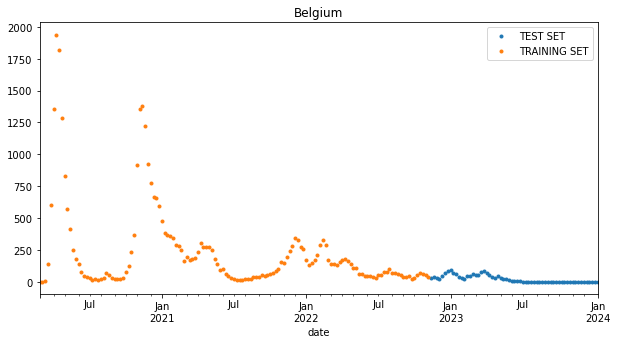

In [28]:
_ = belgium_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(belgium_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Belgium', style='.')

## basic ARIMA (1,0,1)

In [29]:
model=ARIMA(belgium_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -832.504
Date:                Tue, 05 Mar 2024   AIC                           1673.008
Time:                        14:37:08   BIC                           1684.803
Sample:                    03-01-2020   HQIC                          1677.801
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        211.7884    203.043      1.043      0.297    -186.168     609.744
ar.L1          0.8830      0.026     34.162      0.000       0.832       0.934
ma.L1          0.8603      0.061     14.180      0.000       0.741       0.979
sigma2      7649.3102    535.216     14.292      0.000    6600.306    8698.315
===================================================================================
Ljung-Box (L1) (Q):                  16.44   Jarque-Bera (JB):              1725.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             3.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

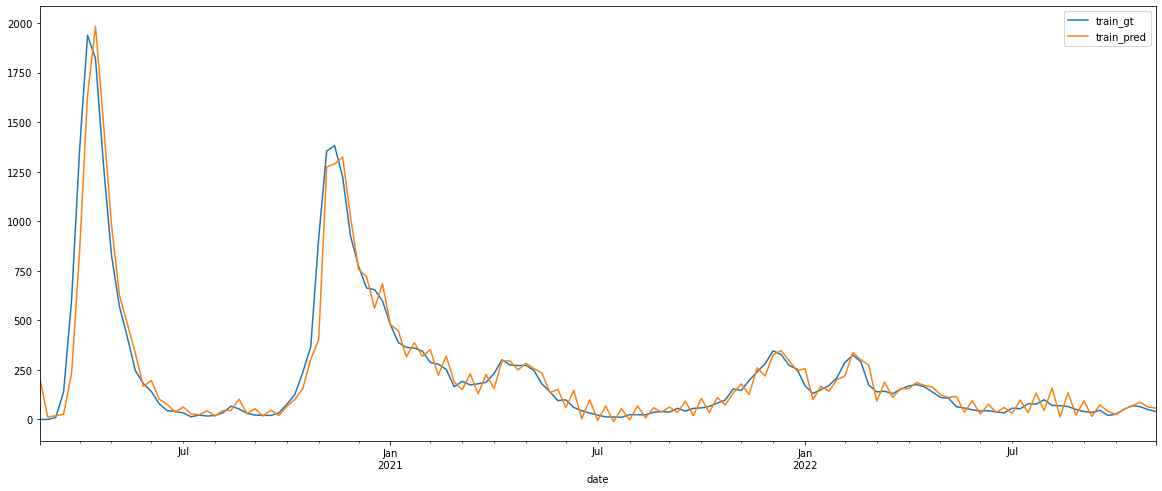

In [30]:
train_pred=model_fit.fittedvalues
pd.concat([belgium_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

<AxesSubplot:xlabel='date'>

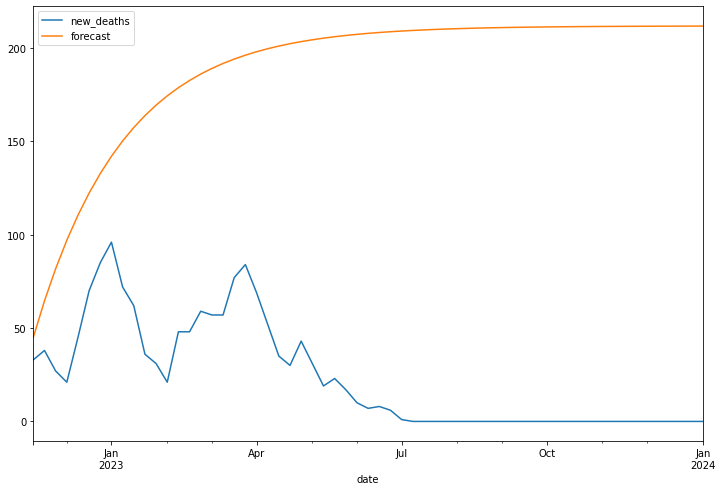

In [31]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [32]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test['new_deaths'], belgium_test['forecast'], y_train = belgium_train['new_deaths'])
new_row = {'country': 'Belgium', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)


## grid search ARIMA

In [33]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(belgium_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
2,1,3,1620.798576
6,2,3,1622.403203
3,1,4,1622.539132
10,3,3,1623.146503
7,2,4,1624.405232
11,3,4,1625.583947
12,4,1,1628.912059
8,3,1,1629.449759
5,2,2,1629.454643
9,3,2,1629.639760


In [34]:
model=ARIMA(belgium_train['new_deaths'],order=(1,0,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -804.399
Date:                Tue, 05 Mar 2024   AIC                           1620.799
Time:                        14:37:32   BIC                           1638.491
Sample:                    03-01-2020   HQIC                          1627.988
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        233.4577    133.322      1.751      0.080     -27.848     494.763
ar.L1          0.6863      0.051     13.499      0.000       0.587       0.786
ma.L1          1.4308      0.071     20.079      0.000       1.291       1.570
ma.L2          1.1488      0.121      9.465      0.000       0.911       1.387
ma.L3          0.5255      0.109      4.821      0.000       0.312       0.739
sigma2      5094.7025    323.883     15.730      0.000    4459.904    5729.501
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1800.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

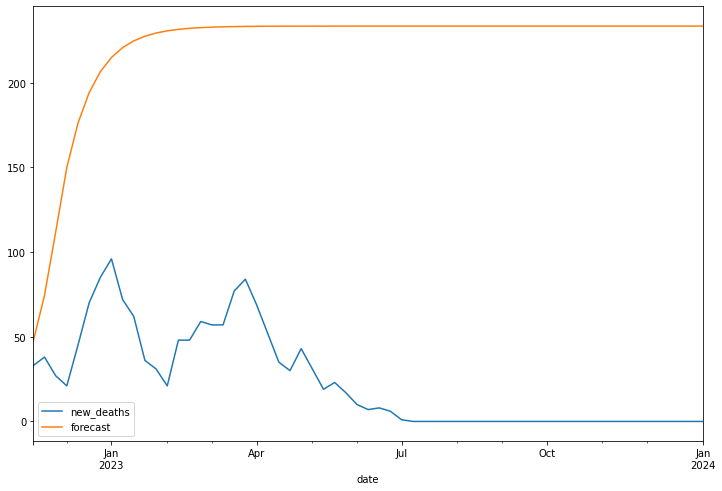

In [35]:
belgium_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [36]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test['new_deaths'], belgium_test['forecast'], y_train = belgium_train['new_deaths'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
new_row = {'country': 'Belgium', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [37]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,13)).fit()
                    results.append([p,q,P,Q,model.aic])



1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68224D+00    |proj g|=  1.80594D+00

At iterate    5    f=  5.91269D+00    |proj g|=  2.49978D-02


 This problem is unconstrained.



At iterate   10    f=  5.91065D+00    |proj g|=  1.78898D-02

At iterate   15    f=  5.90947D+00    |proj g|=  7.49924D-04

At iterate   20    f=  5.90944D+00    |proj g|=  1.96305D-03

At iterate   25    f=  5.90936D+00    |proj g|=  7.37398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     28      1     0     0   3.438D-06   5.909D+00
  F =   5.9093567744500985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.90707D+00    |proj g|=  9.77005D-03

At iterate   10    f=  5.90513D+00    |proj g|=  8.70465D-03

At iterate   15    f=  5.90446D+00    |proj g|=  3.69773D-04

At iterate   20    f=  5.90431D+00    |proj g|=  2.30976D-03

At iterate   25    f=  5.90419D+00    |proj g|=  2.33394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   2.334D-05   5.904D+00
  F =   5.9041862475005429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate   10    f=  5.90223D+00    |proj g|=  1.45070D-03

At iterate   15    f=  5.90212D+00    |proj g|=  1.20849D-03

At iterate   20    f=  5.90205D+00    |proj g|=  2.56186D-03

At iterate   25    f=  5.90173D+00    |proj g|=  2.89676D-03

At iterate   30    f=  5.90170D+00    |proj g|=  9.52034D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   7.144D-06   5.902D+00
  F =   5.9016979793332087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76397D+00    |proj g|=  1.91493D+00

At iterate    5    f=  5.90911D+00    |proj g|=  5.11972D-02

At iterate   10    f=  5.90523D+00    |proj g|=  3.50771D-02

At iterate   15    f=  5.89968D+00    |proj g|=  4.35293D-03

At iterate   20    f=  5.89868D+00    |proj g|=  1.10534D-02

At iterate   25    f=  5.89861D+00    |proj g|=  1.81145D-03

At iterate   30    f=  5.89850D+00    |proj g|=  1.95524D-03

At iterate   35    f=  5.89802D+00    |proj g|=  2.70892D-03

At iterate   40    f=  5.89795D+00    |proj g|=  3.52282D-04

At iterate   45    f=  5.89795D+00    |proj g|=  2.67759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  5.85784D+00    |proj g|=  1.15121D-01

At iterate   10    f=  5.85008D+00    |proj g|=  8.25488D-03

At iterate   15    f=  5.84001D+00    |proj g|=  4.31306D-02

At iterate   20    f=  5.80741D+00    |proj g|=  1.44259D-02

At iterate   25    f=  5.80712D+00    |proj g|=  2.57266D-04

At iterate   30    f=  5.80708D+00    |proj g|=  2.99394D-03

At iterate   35    f=  5.80707D+00    |proj g|=  1.24045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   7.121D-06   5.807D+00
  F =   5.8070656404399390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.85245D+00    |proj g|=  2.36736D-02

At iterate   10    f=  5.84811D+00    |proj g|=  8.57420D-03

At iterate   15    f=  5.82856D+00    |proj g|=  4.42184D-02

At iterate   20    f=  5.80715D+00    |proj g|=  5.36298D-02

At iterate   25    f=  5.80310D+00    |proj g|=  1.61340D-03

At iterate   30    f=  5.80160D+00    |proj g|=  1.87002D-02

At iterate   35    f=  5.80059D+00    |proj g|=  4.48160D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     43      1     0     0   2.154D-05   5.801D+00
  F =   5.8005919107838810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.85955D+00    |proj g|=  4.68408D-02

At iterate   10    f=  5.84840D+00    |proj g|=  7.60771D-03

At iterate   15    f=  5.83938D+00    |proj g|=  4.58923D-02

At iterate   20    f=  5.80398D+00    |proj g|=  2.03697D-02

At iterate   25    f=  5.80315D+00    |proj g|=  1.79152D-04

At iterate   30    f=  5.80314D+00    |proj g|=  1.56975D-03

At iterate   35    f=  5.80305D+00    |proj g|=  8.95602D-04

At iterate   40    f=  5.80300D+00    |proj g|=  1.07581D-03

At iterate   45    f=  5.80297D+00    |proj g|=  1.60100D-03

At iterate   50    f=  5.80296D+00    |proj g|=  3.65406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.85071D+00    |proj g|=  3.90768D-02

At iterate   10    f=  5.84537D+00    |proj g|=  8.11302D-03

At iterate   15    f=  5.82499D+00    |proj g|=  1.47348D-02

At iterate   20    f=  5.80752D+00    |proj g|=  2.85539D-02

At iterate   25    f=  5.80680D+00    |proj g|=  5.63302D-04

At iterate   30    f=  5.80555D+00    |proj g|=  4.38017D-02

At iterate   35    f=  5.80166D+00    |proj g|=  4.33239D-03

At iterate   40    f=  5.80148D+00    |proj g|=  2.55256D-04

At iterate   45    f=  5.80146D+00    |proj g|=  7.22243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     64   

 This problem is unconstrained.



At iterate   10    f=  5.77886D+00    |proj g|=  1.15705D-03

At iterate   15    f=  5.77880D+00    |proj g|=  3.14971D-04

At iterate   20    f=  5.77875D+00    |proj g|=  4.78551D-03

At iterate   25    f=  5.77866D+00    |proj g|=  2.41475D-04

At iterate   30    f=  5.77866D+00    |proj g|=  6.25029D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     32      1     0     0   6.250D-06   5.779D+00
  F =   5.7786592205533571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.77887D+00    |proj g|=  1.23027D-02

At iterate   10    f=  5.77810D+00    |proj g|=  2.81917D-03

At iterate   15    f=  5.77609D+00    |proj g|=  8.39201D-03

At iterate   20    f=  5.77534D+00    |proj g|=  3.54166D-03

At iterate   25    f=  5.77513D+00    |proj g|=  2.09624D-03

At iterate   30    f=  5.77512D+00    |proj g|=  4.52155D-04

At iterate   35    f=  5.77505D+00    |proj g|=  2.25022D-03

At iterate   40    f=  5.77504D+00    |proj g|=  9.11418D-05

At iterate   45    f=  5.77504D+00    |proj g|=  5.81408D-04

At iterate   50    f=  5.77504D+00    |proj g|=  1.86944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.77898D+00    |proj g|=  6.11821D-03

At iterate   10    f=  5.77880D+00    |proj g|=  3.31253D-04

At iterate   15    f=  5.77876D+00    |proj g|=  3.87259D-03

At iterate   20    f=  5.77866D+00    |proj g|=  1.62684D-04

At iterate   25    f=  5.77865D+00    |proj g|=  6.34255D-04

At iterate   30    f=  5.77865D+00    |proj g|=  5.58525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   6.798D-06   5.779D+00
  F =   5.7786465402158935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.77694D+00    |proj g|=  1.05014D-02

At iterate   10    f=  5.77631D+00    |proj g|=  1.13840D-02

At iterate   15    f=  5.77581D+00    |proj g|=  1.41639D-03

At iterate   20    f=  5.77559D+00    |proj g|=  8.57469D-03

At iterate   25    f=  5.77488D+00    |proj g|=  2.50138D-03

At iterate   30    f=  5.77478D+00    |proj g|=  1.22552D-04

At iterate   35    f=  5.77478D+00    |proj g|=  3.38538D-04

At iterate   40    f=  5.77475D+00    |proj g|=  1.97795D-03

At iterate   45    f=  5.77474D+00    |proj g|=  1.18725D-04

At iterate   50    f=  5.77474D+00    |proj g|=  2.70164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82244D+00    |proj g|=  1.46986D-02

At iterate   10    f=  5.80589D+00    |proj g|=  8.71438D-02

At iterate   15    f=  5.77127D+00    |proj g|=  3.84473D-02

At iterate   20    f=  5.75755D+00    |proj g|=  7.37551D-03

At iterate   25    f=  5.75435D+00    |proj g|=  7.13278D-03

At iterate   30    f=  5.75114D+00    |proj g|=  3.65142D-04

At iterate   35    f=  5.75114D+00    |proj g|=  4.18505D-04

At iterate   40    f=  5.75109D+00    |proj g|=  3.37723D-03

At iterate   45    f=  5.75069D+00    |proj g|=  3.68029D-03

At iterate   50    f=  5.75066D+00    |proj g|=  2.69274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81776D+00    |proj g|=  3.33347D-02

At iterate   10    f=  5.80969D+00    |proj g|=  4.85531D-02

At iterate   15    f=  5.76278D+00    |proj g|=  4.41202D-02

At iterate   20    f=  5.75733D+00    |proj g|=  1.73686D-03

At iterate   25    f=  5.75729D+00    |proj g|=  3.04783D-03

At iterate   30    f=  5.75345D+00    |proj g|=  6.74994D-02

At iterate   35    f=  5.75126D+00    |proj g|=  3.41529D-03

At iterate   40    f=  5.75124D+00    |proj g|=  2.36107D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     52      1     0     0   1.177D-05   5.751D+00
  F =   5.75123625863

 This problem is unconstrained.



At iterate    5    f=  5.82073D+00    |proj g|=  1.00029D-02

At iterate   10    f=  5.80709D+00    |proj g|=  2.58265D-02

At iterate   15    f=  5.76698D+00    |proj g|=  3.60670D-02

At iterate   20    f=  5.75104D+00    |proj g|=  1.20312D-02

At iterate   25    f=  5.75063D+00    |proj g|=  1.03472D-04

At iterate   30    f=  5.75062D+00    |proj g|=  1.54717D-03

At iterate   35    f=  5.75060D+00    |proj g|=  3.27226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     41      1     0     0   1.384D-05   5.751D+00
  F =   5.7506010539610024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.81243D+00    |proj g|=  1.32183D-02

At iterate   10    f=  5.78769D+00    |proj g|=  5.23839D-02

At iterate   15    f=  5.75989D+00    |proj g|=  3.56865D-02

At iterate   20    f=  5.75274D+00    |proj g|=  1.33843D-02

At iterate   25    f=  5.75116D+00    |proj g|=  7.45911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     38      1     0     0   7.458D-04   5.751D+00
  F =   5.7511630263104330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [38]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,1635.685899
14,2,2,2,1,1637.669497
13,2,2,1,2,1637.848625
15,2,2,2,2,1639.827973
8,2,1,1,1,1641.581900
9,2,1,1,2,1642.560079
10,2,1,2,1,1643.578324
11,2,1,2,2,1644.477312
4,1,2,1,1,1649.592511
5,1,2,1,2,1649.766919


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97788D+00    |proj g|=  5.47422D-01

At iterate    5    f=  5.82244D+00    |proj g|=  1.46986D-02


 This problem is unconstrained.



At iterate   10    f=  5.80589D+00    |proj g|=  8.71438D-02

At iterate   15    f=  5.77127D+00    |proj g|=  3.84473D-02

At iterate   20    f=  5.75755D+00    |proj g|=  7.37551D-03

At iterate   25    f=  5.75435D+00    |proj g|=  7.13278D-03

At iterate   30    f=  5.75114D+00    |proj g|=  3.65142D-04

At iterate   35    f=  5.75114D+00    |proj g|=  4.18505D-04

At iterate   40    f=  5.75109D+00    |proj g|=  3.37723D-03

At iterate   45    f=  5.75069D+00    |proj g|=  3.68029D-03

At iterate   50    f=  5.75066D+00    |proj g|=  2.69274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

<AxesSubplot:xlabel='date'>

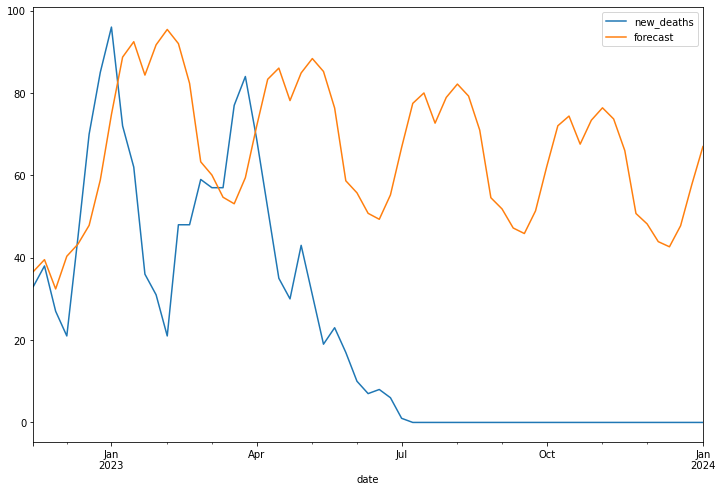

In [39]:
model=sm.tsa.statespace.SARIMAX(belgium_train['new_deaths'],order=(2, 0, 2),seasonal_order=(1,0,1,13))
results=model.fit()
belgium_test['forecast']=results.predict(start=141,end=202,dynamic=True)
belgium_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [40]:
mae = mean_absolute_error(belgium_test['new_deaths'], belgium_test['forecast'])
r2 = r2_score(belgium_test['new_deaths'], belgium_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test['new_deaths'], belgium_test['forecast'], y_train = belgium_train['new_deaths'])
new_row = {'country': 'Belgium', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [41]:
auto_model = auto_arima(belgium_train['new_deaths'], seasonal=True, m=13, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods = len(belgium_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 1, 2)   Log Likelihood                -802.051
Date:                Tue, 05 Mar 2024   AIC                           1618.101
Time:                        14:38:38   BIC                           1638.693
Sample:                    03-01-2020   HQIC                          1626.469
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1013      0.110      9.976      0.000       0.885       1.318
ar.L2          0.1946      0.220      0.885      0.376      -0.236       0.625
ar.L3         -0.8166      0.232     -3.516      0.0

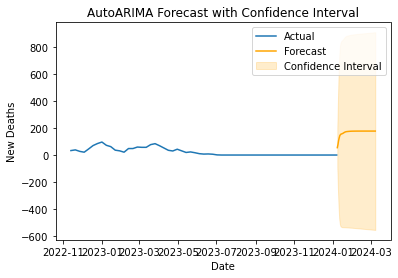

In [42]:
forecast_index = pd.date_range(belgium_test.index[-1], periods=n_periods + 1, freq=belgium_test.index.freq)[-n_periods:]

plt.plot(belgium_test.index, belgium_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [43]:
mae = mean_absolute_error(belgium_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(belgium_test['new_deaths'], forecast, y_train = belgium_train['new_deaths'])
r2 = r2_score(belgium_test['new_deaths'], forecast)
new_row = {'country': 'Belgium', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

In [44]:
metrics

,country,model,mae,mase,rsq
0,Belgium,Basic ARIMA,165.191065,0.610829,-38.595632
1,Belgium,Grid Search ARIMA,198.195833,0.732871,-52.903511
2,Belgium,SARIMA,46.290089,0.171167,-2.494062
3,Belgium,autoARIMA,144.963019,0.536032,-28.241591


# Chile

## train/test split

In [227]:
chile = pd.read_csv('univariate_df_Chile.csv')
chile = chile.set_index('date')
chile.index = pd.to_datetime(chile.index)
chile = chile.drop('Unnamed: 0', axis=1)

In [228]:
chile.sort_index()
train_size = int(len(chile) * 0.7)
chile_train, chile_test = chile[0:train_size], belgium[train_size:]
print(chile_train.shape, chile_test.shape)

(141, 1) (61, 1)


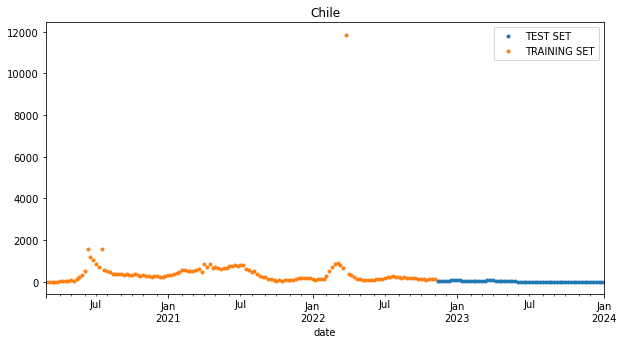

In [229]:
_ = chile_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(chile_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Chile', style='.')

## basic ARIMA (1,0,1)

In [230]:
model=ARIMA(chile_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1174.009
Date:                Tue, 27 Feb 2024   AIC                           2356.018
Time:                        18:36:52   BIC                           2367.813
Sample:                    03-01-2020   HQIC                          2360.811
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        438.2168    466.712      0.939      0.348    -476.522    1352.956
ar.L1          0.7085      0.660      1.073      0.283      -0.585       2.002
ma.L1         -0.6115      0.687     -0.890      0.374      -1.959       0.736
sigma2      1.023e+06   6.14e+04     16.655      0.000    9.03e+05    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             80252.95
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              28.79   Skew:                            10.39
Prob(H) (two-sided):                  0.00   Kurtosis:                       118.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

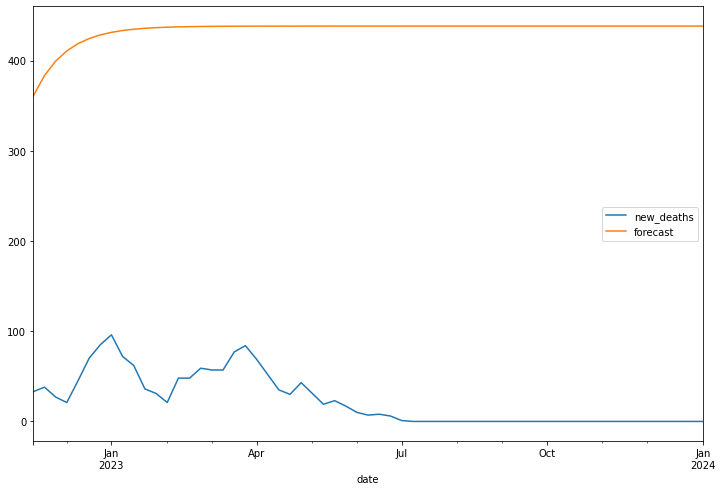

In [231]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [232]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(chile_test['new_deaths'], chile_test['forecast'], y_train = chile_train['new_deaths'])
new_row = {'country': 'Chile', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [233]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(chile_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
5,2,2,2346.802121
9,3,2,2350.253052
6,2,3,2350.468350
7,2,4,2354.412644
13,4,2,2355.642824
0,1,1,2356.018009
4,2,1,2357.821757
1,1,2,2357.927563
14,4,3,2358.078996
11,3,4,2358.463948


In [234]:
model=ARIMA(chile_train['new_deaths'],order=(2,0,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1167.401
Date:                Tue, 27 Feb 2024   AIC                           2346.802
Time:                        18:37:08   BIC                           2364.495
Sample:                    03-01-2020   HQIC                          2353.992
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        481.1356     66.087      7.280      0.000     351.608     610.663
ar.L1          1.9418      0.058     33.620      0.000       1.829       2.055
ar.L2         -0.9597      0.058    -16.485      0.000      -1.074      -0.846
ma.L1         -1.9946      0.113    -17.663      0.000      -2.216      -1.773
ma.L2          0.9988      0.113      8.871      0.000       0.778       1.219
sigma2      8.723e+05      0.000   6.05e+09      0.000    8.72e+05    8.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             71395.95
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              23.01   Skew:                             9.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       111.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.79e+26. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

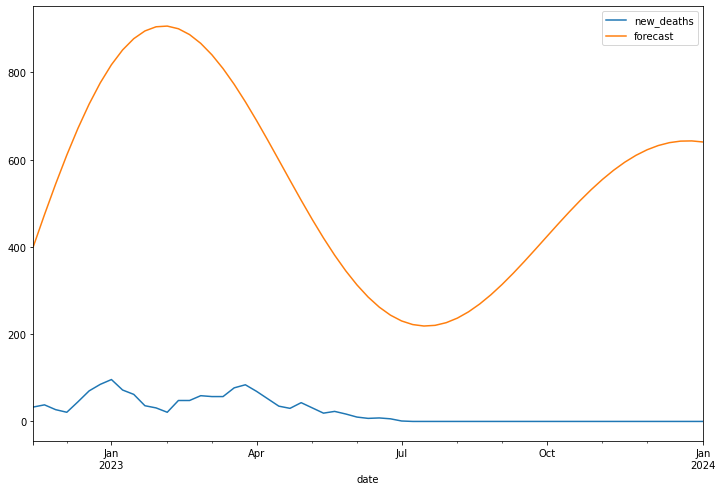

In [235]:
chile_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [236]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(chile_test['new_deaths'], chile_test['forecast'], y_train = chile_train['new_deaths'])
new_row = {'country': 'Chile', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [237]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38087D+00    |proj g|=  1.17090D-01

At iterate    5    f=  8.35294D+00    |proj g|=  1.40348D-03

At iterate   10    f=  8.35205D+00    |proj g|=  3.51558D-03


 This problem is unconstrained.



At iterate   15    f=  8.35025D+00    |proj g|=  8.47633D-04

At iterate   20    f=  8.34968D+00    |proj g|=  1.23033D-03

At iterate   25    f=  8.34852D+00    |proj g|=  1.18943D-03

At iterate   30    f=  8.34845D+00    |proj g|=  6.32441D-04

At iterate   35    f=  8.34836D+00    |proj g|=  3.68493D-03

At iterate   40    f=  8.34828D+00    |proj g|=  3.53838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     57      1     0     0   8.297D-05   8.348D+00
  F =   8.3482695661393471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  8.35071D+00    |proj g|=  4.34031D-03

At iterate   10    f=  8.35054D+00    |proj g|=  1.36704D-03

At iterate   15    f=  8.35049D+00    |proj g|=  1.43831D-03

At iterate   20    f=  8.35047D+00    |proj g|=  4.81053D-04

At iterate   25    f=  8.35009D+00    |proj g|=  4.65018D-03

At iterate   30    f=  8.35007D+00    |proj g|=  2.86403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   5.256D-05   8.350D+00
  F =   8.3500717208626316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  8.35215D+00    |proj g|=  1.77943D-02

At iterate   10    f=  8.35043D+00    |proj g|=  4.52241D-04

At iterate   15    f=  8.35043D+00    |proj g|=  1.02633D-04

At iterate   20    f=  8.35043D+00    |proj g|=  5.64624D-04

At iterate   25    f=  8.35025D+00    |proj g|=  6.25127D-03

At iterate   30    f=  8.35002D+00    |proj g|=  9.50179D-04

At iterate   35    f=  8.35001D+00    |proj g|=  5.36852D-05

At iterate   40    f=  8.34994D+00    |proj g|=  3.69542D-03

At iterate   45    f=  8.34929D+00    |proj g|=  1.95497D-03

At iterate   50    f=  8.34927D+00    |proj g|=  2.55730D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37052D+00    |proj g|=  7.16978D-02

At iterate    5    f=  8.35113D+00    |proj g|=  1.24632D-02

At iterate   10    f=  8.35047D+00    |proj g|=  1.32629D-03

At iterate   15    f=  8.35040D+00    |proj g|=  4.51966D-04

At iterate   20    f=  8.35017D+00    |proj g|=  2.83930D-03

At iterate   25    f=  8.34878D+00    |proj g|=  7.55431D-03

At iterate   30    f=  8.34559D+00    |proj g|=  1.61526D-02

At iterate   35    f=  8.34513D+00    |proj g|=  4.42418D-03

At iterate   40    f=  8.34233D+00    |proj g|=  4.52758D-02

At iterate   45    f=  8.34040D+00    |proj g|=  1.77723D-01

At iterate   50    f=  8.33923D+00    |proj g|=  2.51112D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36981D+00    |proj g|=  1.06965D-01

At iterate    5    f=  8.35125D+00    |proj g|=  1.42808D-03

At iterate   10    f=  8.35122D+00    |proj g|=  1.61264D-03

At iterate   15    f=  8.35117D+00    |proj g|=  6.02517D-05

At iterate   20    f=  8.35117D+00    |proj g|=  6.69738D-04

At iterate   25    f=  8.35086D+00    |proj g|=  1.27971D-02

At iterate   30    f=  8.35063D+00    |proj g|=  9.48853D-04

At iterate   35    f=  8.35062D+00    |proj g|=  2.86213D-04

At iterate   40    f=  8.35058D+00    |proj g|=  1.61698D-03

At iterate   45    f=  8.34991D+00    |proj g|=  4.99681D-03

At iterate   50    f=  8.34983D+00    |proj g|=  9.05157D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35964D+00    |proj g|=  6.16246D-02

At iterate    5    f=  8.35070D+00    |proj g|=  8.16858D-04

At iterate   10    f=  8.35058D+00    |proj g|=  5.72385D-03

At iterate   15    f=  8.35033D+00    |proj g|=  1.90896D-04

At iterate   20    f=  8.35033D+00    |proj g|=  1.15359D-03

At iterate   25    f=  8.34957D+00    |proj g|=  2.68080D-02

At iterate   30    f=  8.34741D+00    |proj g|=  6.20223D-03

At iterate   35    f=  8.34487D+00    |proj g|=  6.29013D-03

At iterate   40    f=  8.34314D+00    |proj g|=  2.54991D-03

At iterate   45    f=  8.34271D+00    |proj g|=  5.50253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  8.35067D+00    |proj g|=  3.51183D-03

At iterate   10    f=  8.35061D+00    |proj g|=  4.01837D-03

At iterate   15    f=  8.35035D+00    |proj g|=  4.12311D-03

At iterate   20    f=  8.35033D+00    |proj g|=  2.58426D-04

At iterate   25    f=  8.35029D+00    |proj g|=  6.42660D-03

At iterate   30    f=  8.34875D+00    |proj g|=  6.77028D-03

At iterate   35    f=  8.34798D+00    |proj g|=  7.04143D-03

At iterate   40    f=  8.34684D+00    |proj g|=  2.46464D-02

At iterate   45    f=  8.34634D+00    |proj g|=  5.78332D-03

At iterate   50    f=  8.34610D+00    |proj g|=  9.01775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.35091D+00    |proj g|=  4.11488D-03

At iterate   10    f=  8.35076D+00    |proj g|=  1.41073D-03

At iterate   15    f=  8.35050D+00    |proj g|=  1.15155D-02

At iterate   20    f=  8.35038D+00    |proj g|=  4.36282D-04

At iterate   25    f=  8.35032D+00    |proj g|=  8.67578D-04

At iterate   30    f=  8.35030D+00    |proj g|=  2.99752D-04

At iterate   35    f=  8.35025D+00    |proj g|=  3.24450D-03

At iterate   40    f=  8.34960D+00    |proj g|=  9.19400D-03

At iterate   45    f=  8.34887D+00    |proj g|=  9.85108D-03

At iterate   50    f=  8.34813D+00    |proj g|=  4.09522D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.35112D+00    |proj g|=  1.56647D-03

At iterate   15    f=  8.35094D+00    |proj g|=  2.14479D-03

At iterate   20    f=  8.35092D+00    |proj g|=  5.31866D-05

At iterate   25    f=  8.35091D+00    |proj g|=  1.47676D-03

At iterate   30    f=  8.35089D+00    |proj g|=  5.21752D-05

At iterate   35    f=  8.35089D+00    |proj g|=  5.56647D-04

At iterate   40    f=  8.35066D+00    |proj g|=  1.51899D-02

At iterate   45    f=  8.35022D+00    |proj g|=  3.96829D-04

At iterate   50    f=  8.35013D+00    |proj g|=  5.49177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.



At iterate    5    f=  8.35036D+00    |proj g|=  5.91193D-03

At iterate   10    f=  8.35028D+00    |proj g|=  3.81600D-03

At iterate   15    f=  8.35004D+00    |proj g|=  4.36357D-03

At iterate   20    f=  8.35003D+00    |proj g|=  1.95211D-04

At iterate   25    f=  8.34982D+00    |proj g|=  8.42981D-03

At iterate   30    f=  8.34864D+00    |proj g|=  1.03522D-02

At iterate   35    f=  8.34626D+00    |proj g|=  9.37414D-03

At iterate   40    f=  8.34563D+00    |proj g|=  6.82755D-03

At iterate   45    f=  8.34398D+00    |proj g|=  1.27097D-02

At iterate   50    f=  8.34259D+00    |proj g|=  2.20140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37246D+00    |proj g|=  1.00260D-01

At iterate    5    f=  8.35050D+00    |proj g|=  1.22580D-02

At iterate   10    f=  8.35023D+00    |proj g|=  9.50304D-04

At iterate   15    f=  8.35007D+00    |proj g|=  8.12403D-03

At iterate   20    f=  8.35002D+00    |proj g|=  3.55129D-04

At iterate   25    f=  8.34888D+00    |proj g|=  2.77851D-02

At iterate   30    f=  8.34706D+00    |proj g|=  2.03973D-03

At iterate   35    f=  8.34574D+00    |proj g|=  2.51445D-02

At iterate   40    f=  8.34318D+00    |proj g|=  6.52256D-03

At iterate   45    f=  8.34215D+00    |proj g|=  1.97734D-03

At iterate   50    f=  8.34206D+00    |proj g|=  2.21535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.35054D+00    |proj g|=  7.48014D-03

At iterate   10    f=  8.35037D+00    |proj g|=  3.01194D-03

At iterate   15    f=  8.35008D+00    |proj g|=  4.67946D-03

At iterate   20    f=  8.35006D+00    |proj g|=  4.70218D-04

At iterate   25    f=  8.34997D+00    |proj g|=  4.47972D-03

At iterate   30    f=  8.34995D+00    |proj g|=  2.21740D-03

At iterate   35    f=  8.34911D+00    |proj g|=  2.51645D-02

At iterate   40    f=  8.34618D+00    |proj g|=  3.76866D-02

At iterate   45    f=  8.34348D+00    |proj g|=  1.12734D-02

At iterate   50    f=  8.33930D+00    |proj g|=  1.37606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.35117D+00    |proj g|=  2.32696D-03

At iterate   10    f=  8.35108D+00    |proj g|=  2.01854D-04

At iterate   15    f=  8.35106D+00    |proj g|=  2.95593D-03

At iterate   20    f=  8.35017D+00    |proj g|=  1.92954D-03

At iterate   25    f=  8.35014D+00    |proj g|=  1.09262D-03

At iterate   30    f=  8.35012D+00    |proj g|=  4.61444D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     39      1     0     0   1.280D-05   8.350D+00
  F =   8.3501190605985656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   15    f=  8.35041D+00    |proj g|=  2.49447D-04

At iterate   20    f=  8.35033D+00    |proj g|=  2.73504D-03

At iterate   25    f=  8.35031D+00    |proj g|=  5.97494D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     28      1     0     0   5.975D-05   8.350D+00
  F =   8.3503110760882020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36647D+00    |proj g|=  9.28394D-02


 This problem is unconstrained.



At iterate    5    f=  8.35055D+00    |proj g|=  1.30617D-03

At iterate   10    f=  8.35039D+00    |proj g|=  2.05504D-03

At iterate   15    f=  8.35037D+00    |proj g|=  1.51973D-04

At iterate   20    f=  8.35035D+00    |proj g|=  2.57450D-03

At iterate   25    f=  8.35030D+00    |proj g|=  2.76276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     32      1     0     0   5.976D-05   8.350D+00
  F =   8.3503043473665333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate   10    f=  8.35050D+00    |proj g|=  8.32633D-03

At iterate   15    f=  8.35034D+00    |proj g|=  1.76337D-04

At iterate   20    f=  8.35034D+00    |proj g|=  9.86172D-04

At iterate   25    f=  8.35032D+00    |proj g|=  7.29582D-05

At iterate   30    f=  8.35032D+00    |proj g|=  1.00709D-03

At iterate   35    f=  8.35030D+00    |proj g|=  4.44071D-04

At iterate   40    f=  8.35030D+00    |proj g|=  5.38141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     48      1     0     0   5.950D-05   8.350D+00
  F =   8.3502968400162576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [238]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
0,1,1,1,1,2364.212018
3,1,1,2,2,2365.663480
10,2,1,2,1,2366.460028
2,1,1,2,1,2366.494514
9,2,1,1,2,2366.609148
5,1,2,1,2,2366.645053
4,1,2,1,1,2366.652705
1,1,1,1,2,2366.720225
8,2,1,1,1,2366.737113
6,1,2,2,1,2367.601261


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38087D+00    |proj g|=  1.17090D-01

At iterate    5    f=  8.35294D+00    |proj g|=  1.40348D-03



At iterate   10    f=  8.35205D+00    |proj g|=  3.51558D-03

At iterate   15    f=  8.35025D+00    |proj g|=  8.47633D-04

At iterate   20    f=  8.34968D+00    |proj g|=  1.23033D-03

At iterate   25    f=  8.34852D+00    |proj g|=  1.18943D-03

At iterate   30    f=  8.34845D+00    |proj g|=  6.32441D-04

At iterate   35    f=  8.34836D+00    |proj g|=  3.68493D-03

At iterate   40    f=  8.34828D+00    |proj g|=  3.53838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     57      1     0     0   8.297D-05   8.348D+00
  F =   8.3482695661393471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

<AxesSubplot:xlabel='date'>

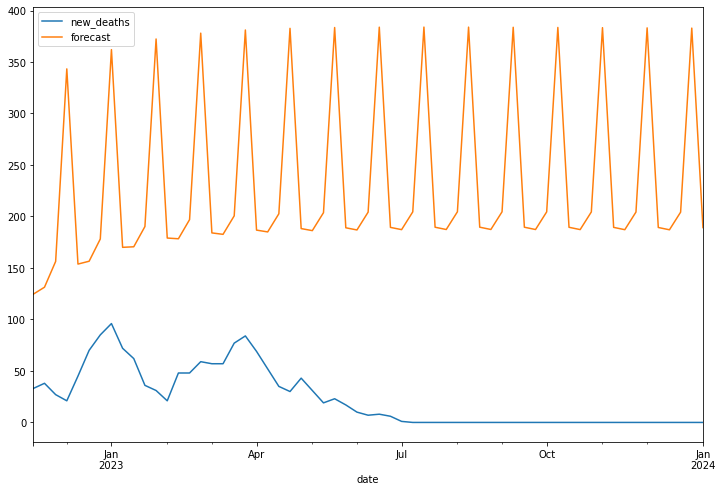

In [239]:
model=sm.tsa.statespace.SARIMAX(chile_train['new_deaths'],order=(1, 0, 1),seasonal_order=(1,0,1,4))
results=model.fit()
chile_test['forecast']=results.predict(start=141,end=202,dynamic=True)
chile_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [240]:
mae = mean_absolute_error(chile_test['new_deaths'], chile_test['forecast'])
r2 = r2_score(chile_test['new_deaths'], chile_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(chile_test['new_deaths'], chile_test['forecast'], y_train = chile_train['new_deaths'])
new_row = {'country': 'Chile', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [241]:
auto_model = auto_arima(chile_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(chile_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:                        SARIMAX   Log Likelihood               -1175.312
Date:                Tue, 27 Feb 2024   AIC                           2354.623
Time:                        18:37:30   BIC                           2360.521
Sample:                    03-01-2020   HQIC                          2357.020
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    438.2199    298.221      1.469      0.142    -146.283    1022.723
sigma2      1.018e+06    5.6e+04     18.175      0.000    9.08e+05    1.13e+06
Ljung-Box (L1) (Q):                   1.19   Jarque-

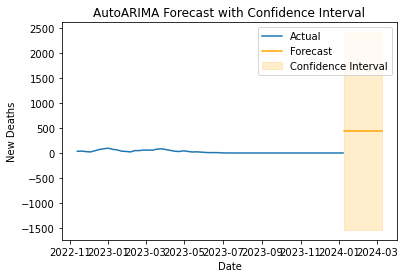

In [242]:
forecast_index = pd.date_range(chile_test.index[-1], periods=n_periods + 1, freq=chile_test.index.freq)[-n_periods:]

plt.plot(chile_test.index, chile_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [243]:
mae = mean_absolute_error(chile_test['new_deaths'], forecast)
r2 = r2_score(chile_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(chile_test['new_deaths'], forecast, y_train = chile_train['new_deaths'])
new_row = {'country': 'Chile', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Ireland

## train/test split

In [244]:
ireland = pd.read_csv('univariate_df_Ireland.csv')
ireland = ireland.set_index('date')
ireland.index = pd.to_datetime(ireland.index)
ireland = ireland.drop('Unnamed: 0', axis=1)

In [245]:
ireland.sort_index()
train_size = int(len(ireland) * 0.7)
ireland_train, ireland_test = ireland[0:train_size], ireland[train_size:]
print(ireland_train.shape, ireland_test.shape)

(141, 1) (61, 1)


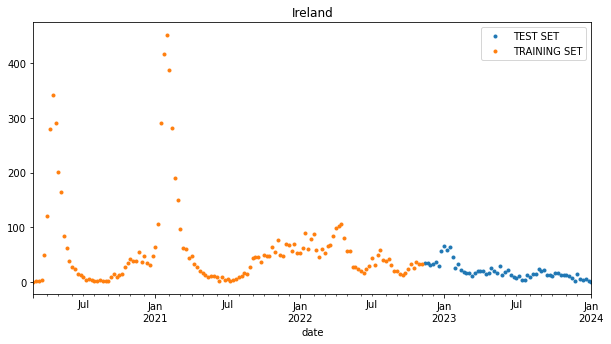

In [246]:
_ = ireland_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(ireland_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Ireland', style='.')

## basic ARIMA (1,0,1)

In [247]:
model=ARIMA(ireland_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -662.637
Date:                Tue, 27 Feb 2024   AIC                           1333.275
Time:                        18:37:31   BIC                           1345.070
Sample:                    03-01-2020   HQIC                          1338.068
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.7532     40.098      1.365      0.172     -23.838     133.344
ar.L1          0.8634      0.037     23.349      0.000       0.791       0.936
ma.L1          0.5461      0.063      8.637      0.000       0.422       0.670
sigma2       694.7326     37.626     18.464      0.000     620.988     768.477
===================================================================================
Ljung-Box (L1) (Q):                   5.91   Jarque-Bera (JB):              1816.25
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             2.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

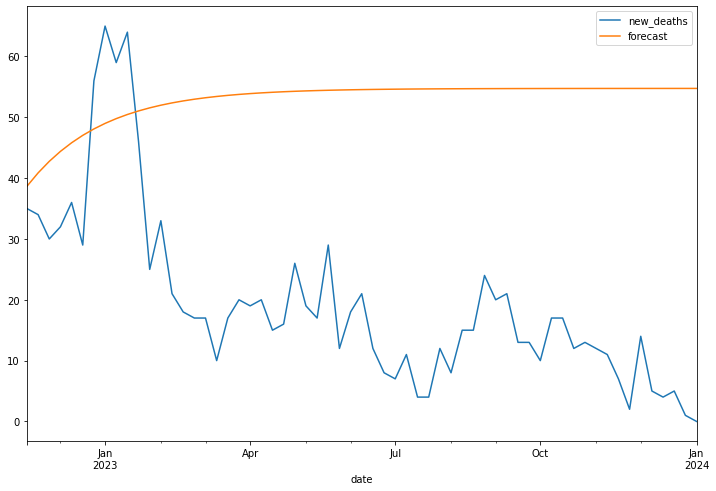

In [248]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [249]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(ireland_test['new_deaths'], ireland_test['forecast'], y_train = ireland_train['new_deaths'])
new_row = {'country': 'Ireland', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [250]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(ireland_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
7,2,4,1307.792020
12,4,1,1307.976061
4,2,1,1309.206180
11,3,4,1309.754951
3,1,4,1310.056604
10,3,3,1310.179709
5,2,2,1310.710871
8,3,1,1310.775047
13,4,2,1311.161055
6,2,3,1312.355228


In [251]:
model=ARIMA(ireland_train['new_deaths'],order=(2,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -645.469
Date:                Tue, 27 Feb 2024   AIC                           1304.937
Time:                        18:37:42   BIC                           1325.529
Sample:                    03-01-2020   HQIC                          1313.305
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2584      0.272      4.623      0.000       0.725       1.792
ar.L2         -0.4507      0.237     -1.899      0.058      -0.916       0.015
ma.L1         -0.7013     12.858     -0.055      0.957     -25.902      24.500
ma.L2         -0.0793      3.928     -0.020      0.984      -7.777       7.619
ma.L3         -0.1239      2.852     -0.043      0.965      -5.714       5.467
ma.L4         -0.0954      1.303     -0.073      0.942      -2.650       2.459
sigma2       576.1042   7453.833      0.077      0.938    -1.4e+04    1.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1856.93
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

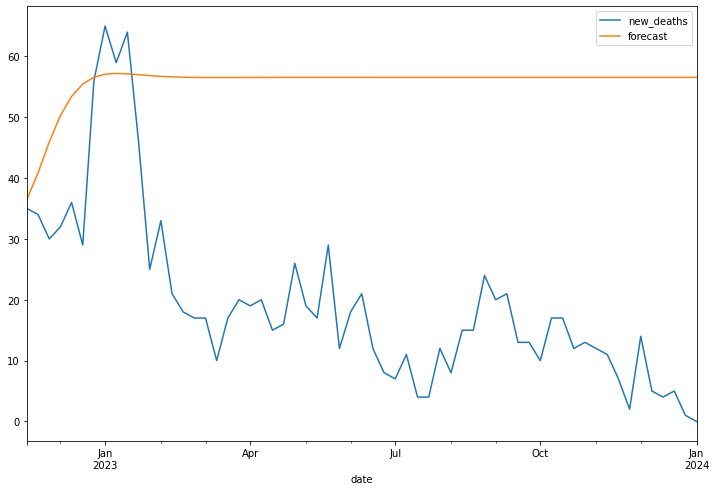

In [252]:
ireland_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [253]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(ireland_test['new_deaths'], ireland_test['forecast'], y_train = ireland_train['new_deaths'])
new_row = {'country': 'Ireland', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [254]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01733D+01    |proj g|=  4.80520D+00

At iterate    5    f=  4.76483D+00    |proj g|=  6.91605D-02


 This problem is unconstrained.



At iterate   10    f=  4.71869D+00    |proj g|=  7.07133D-03

At iterate   15    f=  4.71303D+00    |proj g|=  1.78617D-03

At iterate   20    f=  4.71006D+00    |proj g|=  1.33751D-03

At iterate   25    f=  4.70929D+00    |proj g|=  3.32497D-04

At iterate   30    f=  4.70929D+00    |proj g|=  4.95186D-05

At iterate   35    f=  4.70890D+00    |proj g|=  2.32356D-03

At iterate   40    f=  4.70702D+00    |proj g|=  3.67530D-04

At iterate   45    f=  4.70702D+00    |proj g|=  1.29132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     59      1     0     0   1.291D-06   4.707D+00
  F =   4.70701728931

 This problem is unconstrained.



At iterate   15    f=  4.70597D+00    |proj g|=  7.70850D-03

At iterate   20    f=  4.70592D+00    |proj g|=  3.69297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   3.693D-05   4.706D+00
  F =   4.7059237300886165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82752D+00    |proj g|=  3.63494D-01

At iterate    5    f=  4.70938D+00    |proj g|=  1.20179D-02


 This problem is unconstrained.



At iterate   20    f=  4.70590D+00    |proj g|=  1.24263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   3.594D-06   4.706D+00
  F =   4.7058951150483761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85358D+00    |proj g|=  4.21456D-01


 This problem is unconstrained.



At iterate    5    f=  4.70979D+00    |proj g|=  1.08990D-02

At iterate   10    f=  4.70757D+00    |proj g|=  9.94023D-03

At iterate   15    f=  4.70658D+00    |proj g|=  9.20462D-03

At iterate   20    f=  4.70613D+00    |proj g|=  1.47144D-03

At iterate   25    f=  4.70589D+00    |proj g|=  2.20663D-04

At iterate   30    f=  4.70236D+00    |proj g|=  2.06323D-02

At iterate   35    f=  4.69077D+00    |proj g|=  1.16896D-02

At iterate   40    f=  4.66891D+00    |proj g|=  1.63205D-02

At iterate   45    f=  4.66601D+00    |proj g|=  4.19923D-03

At iterate   50    f=  4.66575D+00    |proj g|=  1.12977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27006D+01    |proj g|=  7.09603D+00

At iterate    5    f=  4.80804D+00    |proj g|=  3.24729D-01

At iterate   10    f=  4.71069D+00    |proj g|=  9.35770D-02

At iterate   15    f=  4.66092D+00    |proj g|=  7.75656D-03

At iterate   20    f=  4.65665D+00    |proj g|=  1.91928D-03

At iterate   25    f=  4.65456D+00    |proj g|=  1.35924D-02

At iterate   30    f=  4.65320D+00    |proj g|=  1.56657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     35     

 This problem is unconstrained.



At iterate   10    f=  4.64444D+00    |proj g|=  8.12938D-03

At iterate   15    f=  4.64222D+00    |proj g|=  8.73577D-03

At iterate   20    f=  4.64215D+00    |proj g|=  2.26866D-04

At iterate   25    f=  4.64171D+00    |proj g|=  4.46053D-02

At iterate   30    f=  4.63544D+00    |proj g|=  1.46529D-02

At iterate   35    f=  4.62769D+00    |proj g|=  1.47212D-02

At iterate   40    f=  4.62391D+00    |proj g|=  6.39852D-03

At iterate   45    f=  4.62306D+00    |proj g|=  9.52755D-04

At iterate   50    f=  4.62300D+00    |proj g|=  8.00858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.



At iterate    5    f=  4.64751D+00    |proj g|=  1.49737D-02

At iterate   10    f=  4.64470D+00    |proj g|=  4.52952D-03

At iterate   15    f=  4.64309D+00    |proj g|=  6.82932D-03

At iterate   20    f=  4.64197D+00    |proj g|=  1.67182D-04

At iterate   25    f=  4.64197D+00    |proj g|=  5.00833D-04

At iterate   30    f=  4.64197D+00    |proj g|=  6.50411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   5.455D-05   4.642D+00
  F =   4.6419657756403980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  4.64535D+00    |proj g|=  4.67969D-03

At iterate   15    f=  4.64300D+00    |proj g|=  1.62961D-02

At iterate   20    f=  4.64230D+00    |proj g|=  6.02812D-03

At iterate   25    f=  4.64185D+00    |proj g|=  5.87970D-03

At iterate   30    f=  4.64071D+00    |proj g|=  1.18400D-02

At iterate   35    f=  4.63612D+00    |proj g|=  1.02532D-02

At iterate   40    f=  4.63467D+00    |proj g|=  1.24356D-02

At iterate   45    f=  4.63250D+00    |proj g|=  2.95091D-02

At iterate   50    f=  4.62494D+00    |proj g|=  6.41472D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.



At iterate   10    f=  4.64631D+00    |proj g|=  7.75968D-03

At iterate   15    f=  4.64046D+00    |proj g|=  9.53786D-03

At iterate   20    f=  4.63932D+00    |proj g|=  2.18179D-03

At iterate   25    f=  4.63852D+00    |proj g|=  3.37009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   1.878D-05   4.639D+00
  F =   4.6385179786139270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  4.63483D+00    |proj g|=  4.01837D-03

At iterate   10    f=  4.63461D+00    |proj g|=  3.76782D-03

At iterate   15    f=  4.63442D+00    |proj g|=  1.66818D-03

At iterate   20    f=  4.63388D+00    |proj g|=  7.26458D-03

At iterate   25    f=  4.63371D+00    |proj g|=  2.42725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   2.427D-05   4.634D+00
  F =   4.6337069957174153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  4.63410D+00    |proj g|=  4.92995D-03

At iterate   10    f=  4.63393D+00    |proj g|=  2.57718D-03

At iterate   15    f=  4.63365D+00    |proj g|=  1.45601D-03

At iterate   20    f=  4.63245D+00    |proj g|=  2.57448D-02

At iterate   25    f=  4.62292D+00    |proj g|=  1.56621D-02

At iterate   30    f=  4.61348D+00    |proj g|=  7.90170D-03

At iterate   35    f=  4.61037D+00    |proj g|=  4.98995D-03

At iterate   40    f=  4.60943D+00    |proj g|=  3.15662D-03

At iterate   45    f=  4.60922D+00    |proj g|=  5.11533D-04
  ys=-4.487E-04  -gs= 1.352E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate   10    f=  4.61834D+00    |proj g|=  3.11279D-02

At iterate   15    f=  4.61156D+00    |proj g|=  3.34783D-03

At iterate   20    f=  4.61084D+00    |proj g|=  1.66849D-03

At iterate   25    f=  4.61043D+00    |proj g|=  4.36997D-04

At iterate   30    f=  4.61006D+00    |proj g|=  2.49391D-03

At iterate   35    f=  4.60920D+00    |proj g|=  8.10596D-03

At iterate   40    f=  4.60867D+00    |proj g|=  6.12918D-04

At iterate   45    f=  4.60866D+00    |proj g|=  3.11906D-04

At iterate   50    f=  4.60865D+00    |proj g|=  5.44039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate    5    f=  4.81008D+00    |proj g|=  1.41382D-01

At iterate   10    f=  4.67391D+00    |proj g|=  1.42007D-01

At iterate   15    f=  4.64741D+00    |proj g|=  3.76268D-02

At iterate   20    f=  4.63674D+00    |proj g|=  8.83419D-03

At iterate   25    f=  4.63663D+00    |proj g|=  2.94491D-03

At iterate   30    f=  4.63553D+00    |proj g|=  3.90419D-03

At iterate   35    f=  4.63458D+00    |proj g|=  1.85639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     43      1     0     0   1.521D-05   4.635D+00
  F =   4.6345832981157873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.63473D+00    |proj g|=  1.22254D-02

At iterate   15    f=  4.63258D+00    |proj g|=  1.57930D-02

At iterate   20    f=  4.63188D+00    |proj g|=  6.54219D-04

At iterate   25    f=  4.63186D+00    |proj g|=  3.92610D-03

At iterate   30    f=  4.63129D+00    |proj g|=  3.72768D-03

At iterate   35    f=  4.63123D+00    |proj g|=  1.05709D-03

At iterate   40    f=  4.63123D+00    |proj g|=  5.15679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     50      1     0     0   1.895D-05   4.631D+00
  F =   4.6312284801845651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  4.63145D+00    |proj g|=  2.45160D-04

At iterate   25    f=  4.63143D+00    |proj g|=  1.68497D-03

At iterate   30    f=  4.63124D+00    |proj g|=  2.58613D-03

At iterate   35    f=  4.63123D+00    |proj g|=  3.32114D-04

At iterate   40    f=  4.63123D+00    |proj g|=  9.54716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     47      1     0     0   9.547D-05   4.631D+00
  F =   4.6312279395144467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate    5    f=  4.63587D+00    |proj g|=  1.21927D-02

At iterate   10    f=  4.61774D+00    |proj g|=  3.68809D-02

At iterate   15    f=  4.61176D+00    |proj g|=  2.63209D-02

At iterate   20    f=  4.61082D+00    |proj g|=  2.94763D-03

At iterate   25    f=  4.61044D+00    |proj g|=  3.08063D-03

At iterate   30    f=  4.61029D+00    |proj g|=  7.34803D-04

At iterate   35    f=  4.61021D+00    |proj g|=  1.77530D-03

At iterate   40    f=  4.60969D+00    |proj g|=  3.13852D-03

At iterate   45    f=  4.60898D+00    |proj g|=  1.01573D-02

At iterate   50    f=  4.60861D+00    |proj g|=  3.38736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [255]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
10,2,1,2,1,1313.788388
11,2,1,2,2,1315.638353
15,2,2,2,2,1317.626730
5,1,2,1,2,1317.685470
8,2,1,1,1,1320.062070
7,1,2,2,2,1320.234297
9,2,1,1,2,1320.705373
12,2,2,1,1,1320.952490
14,2,2,2,1,1322.006279
13,2,2,1,2,1322.006431


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76300D+00    |proj g|=  5.27124D-01

At iterate    5    f=  4.63410D+00    |proj g|=  4.92995D-03

At iterate   10    f=  4.63393D+00    |proj g|=  2.57718D-03

At iterate   15    f=  4.63365D+00    |proj g|=  1.45601D-03

At iterate   20    f=  4.63245D+00    |proj g|=  2.57448D-02

At iterate   25    f=  4.62292D+00    |proj g|=  1.56621D-02

At iterate   30    f=  4.61348D+00    |proj g|=  7.90170D-03

At iterate   35    f=  4.61037D+00    |proj g|=  4.98995D-03

At iterate   40    f=  4.60943D+00    |proj g|=  3.15662D-03

At iterate   45    f=  4.60922D+00    |proj g|=  5.11533D-04
  ys=-4.487E-04  -gs= 1.352E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

<AxesSubplot:xlabel='date'>

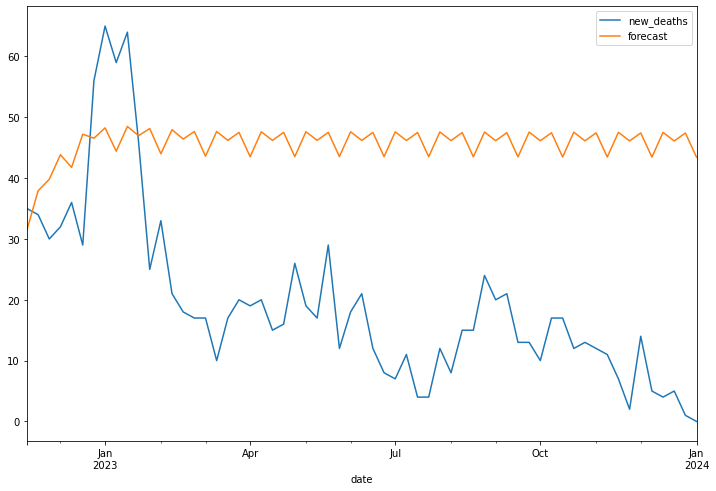

In [256]:
model=sm.tsa.statespace.SARIMAX(ireland_train['new_deaths'],order=(2, 0, 1),seasonal_order=(2,0,1,4))
results=model.fit()
ireland_test['forecast']=results.predict(start=141,end=202,dynamic=True)
ireland_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [257]:
mae = mean_absolute_error(ireland_test['new_deaths'], ireland_test['forecast'])
r2 = r2_score(ireland_test['new_deaths'], ireland_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(ireland_test['new_deaths'], ireland_test['forecast'], y_train = ireland_train['new_deaths'])
new_row = {'country': 'Ireland', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [258]:
auto_model = auto_arima(ireland_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(ireland_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -649.850
Date:                Tue, 27 Feb 2024   AIC                           1307.700
Time:                        18:38:09   BIC                           1319.495
Sample:                    03-01-2020   HQIC                          1312.493
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.2423      4.251      1.939      0.052      -0.089      16.573
ar.L1          1.5153      0.050     30.475      0.000       1.418       1.613
ar.L2         -0.6593      0.050    -13.281      0.0

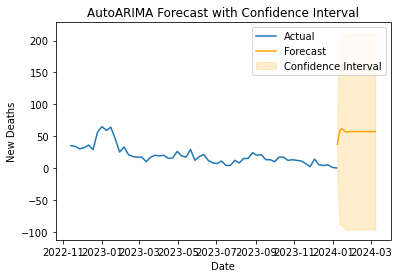

In [259]:
forecast_index = pd.date_range(ireland_test.index[-1], periods=n_periods + 1, freq=ireland_test.index.freq)[-n_periods:]

plt.plot(ireland_test.index, ireland_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [260]:
mae = mean_absolute_error(ireland_test['new_deaths'], forecast)
r2 = r2_score(ireland_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(ireland_test['new_deaths'], forecast, y_train = ireland_train['new_deaths'])
new_row = {'country': 'Ireland', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Israel

## train/test split

In [261]:
israel = pd.read_csv('univariate_df_Israel.csv')
israel = israel.set_index('date')
israel.index = pd.to_datetime(israel.index)
israel = israel.drop('Unnamed: 0', axis=1)
israel.sort_index()
train_size = int(len(israel) * 0.7)
israel_train, israel_test = israel[0:train_size], israel[train_size:]
print(israel_train.shape, israel_test.shape)

(141, 1) (61, 1)


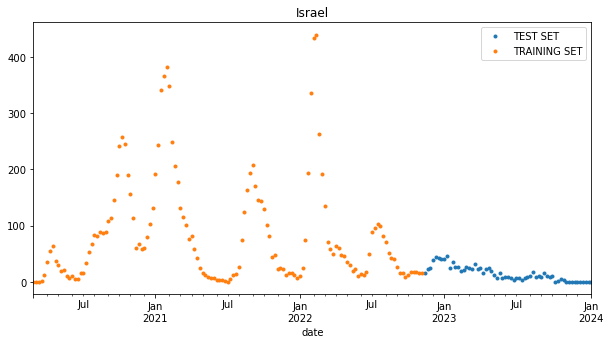

In [262]:
_ = israel_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(israel_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Israel', style='.')

## basic ARIMA (1,0,1)

In [263]:
model=ARIMA(israel_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -663.910
Date:                Tue, 27 Feb 2024   AIC                           1335.820
Time:                        18:38:12   BIC                           1347.615
Sample:                    03-01-2020   HQIC                          1340.613
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.1845     52.210      1.440      0.150     -27.146     177.515
ar.L1          0.8940      0.030     30.206      0.000       0.836       0.952
ma.L1          0.6143      0.051     11.947      0.000       0.514       0.715
sigma2       705.0885     46.688     15.102      0.000     613.582     796.595
===================================================================================
Ljung-Box (L1) (Q):                   5.67   Jarque-Bera (JB):               323.88
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

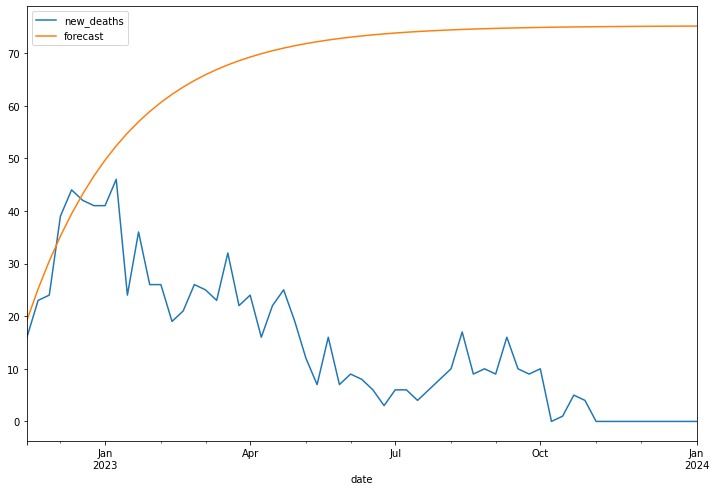

In [264]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [265]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(israel_test['new_deaths'], israel_test['forecast'], y_train = israel_train['new_deaths'])
new_row = {'country': 'Israel', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [266]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(israel_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
6,2,3,1305.144435
2,1,3,1305.688010
8,3,1,1305.969429
3,1,4,1306.473602
7,2,4,1306.569677
10,3,3,1306.617848
4,2,1,1306.618400
13,4,2,1307.085652
14,4,3,1307.208637
5,2,2,1307.296196


In [267]:
model=ARIMA(israel_train['new_deaths'],order=(2,0,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -645.572
Date:                Tue, 27 Feb 2024   AIC                           1305.144
Time:                        18:38:23   BIC                           1325.786
Sample:                    03-01-2020   HQIC                          1313.532
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.1699     34.572      2.319      0.020      12.410     147.930
ar.L1          1.2149      0.239      5.084      0.000       0.747       1.683
ar.L2         -0.3983      0.229     -1.737      0.082      -0.848       0.051
ma.L1          0.4035      0.285      1.418      0.156      -0.154       0.961
ma.L2          0.3556      0.181      1.960      0.050   -7.02e-05       0.711
ma.L3          0.2677      0.168      1.592      0.111      -0.062       0.597
sigma2       541.1029     38.633     14.006      0.000     465.384     616.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               430.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

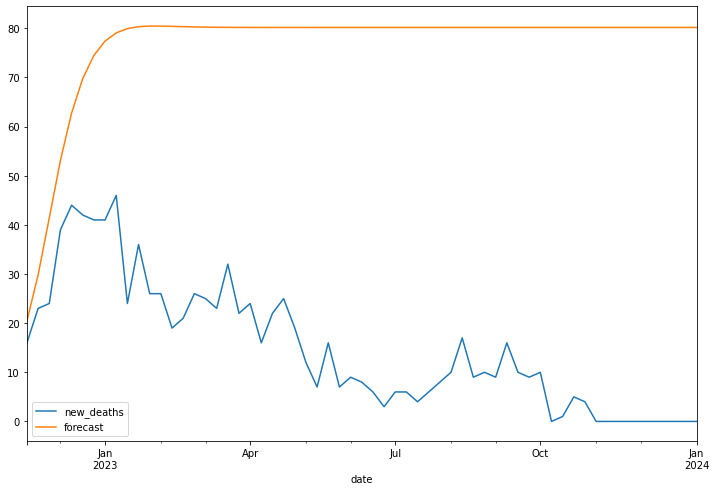

In [268]:
israel_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [269]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(israel_test['new_deaths'], israel_test['forecast'], y_train = israel_train['new_deaths'])
new_row = {'country': 'Israel', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [270]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95949D+00    |proj g|=  6.54677D-01

At iterate    5    f=  4.70829D+00    |proj g|=  1.38621D-02

At iterate   10    f=  4.69698D+00    |proj g|=  1.06625D-02

At iterate   15    f=  4.68906D+00    |proj g|=  1.08179D-02


 This problem is unconstrained.



At iterate   20    f=  4.68768D+00    |proj g|=  9.28366D-04

At iterate   25    f=  4.68761D+00    |proj g|=  2.64692D-03

At iterate   30    f=  4.68722D+00    |proj g|=  2.64649D-03

At iterate   35    f=  4.68703D+00    |proj g|=  2.96068D-03

At iterate   40    f=  4.68693D+00    |proj g|=  7.83067D-04

At iterate   45    f=  4.68691D+00    |proj g|=  9.29152D-05

At iterate   50    f=  4.68690D+00    |proj g|=  3.46985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     52      1     0     0   3.470D-04   4.687D+00
  F =   4.6868976271890226     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  4.68463D+00    |proj g|=  2.36844D-02

At iterate   25    f=  4.68349D+00    |proj g|=  5.93588D-04

At iterate   30    f=  4.68323D+00    |proj g|=  2.39714D-03

At iterate   35    f=  4.68306D+00    |proj g|=  1.07579D-03

At iterate   40    f=  4.68275D+00    |proj g|=  5.76197D-03

At iterate   45    f=  4.68268D+00    |proj g|=  1.62054D-03

At iterate   50    f=  4.68265D+00    |proj g|=  5.51141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   5.511D-04   4.683D+00
  F =   4.6826496037882501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  4.70755D+00    |proj g|=  1.45198D-02

At iterate   10    f=  4.69737D+00    |proj g|=  2.40632D-02

At iterate   15    f=  4.68871D+00    |proj g|=  1.90020D-02

At iterate   20    f=  4.68372D+00    |proj g|=  6.54950D-03

At iterate   25    f=  4.68330D+00    |proj g|=  4.01461D-04

At iterate   30    f=  4.68323D+00    |proj g|=  3.41559D-03

At iterate   35    f=  4.68270D+00    |proj g|=  3.37155D-03

At iterate   40    f=  4.68263D+00    |proj g|=  2.91836D-04

At iterate   45    f=  4.68258D+00    |proj g|=  7.01722D-04

At iterate   50    f=  4.68256D+00    |proj g|=  4.72270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.70947D+00    |proj g|=  1.89721D-02

At iterate   10    f=  4.69845D+00    |proj g|=  3.32011D-02

At iterate   15    f=  4.68480D+00    |proj g|=  2.57856D-02

At iterate   20    f=  4.68348D+00    |proj g|=  7.25580D-04

At iterate   25    f=  4.68341D+00    |proj g|=  2.27404D-03

At iterate   30    f=  4.68281D+00    |proj g|=  2.15196D-03

At iterate   35    f=  4.68254D+00    |proj g|=  6.23686D-04

At iterate   40    f=  4.68252D+00    |proj g|=  4.30566D-05

At iterate   45    f=  4.68252D+00    |proj g|=  3.22123D-04

At iterate   50    f=  4.68250D+00    |proj g|=  1.67987D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.65237D+00    |proj g|=  3.39380D-02

At iterate   10    f=  4.63418D+00    |proj g|=  5.64963D-03

At iterate   15    f=  4.62861D+00    |proj g|=  9.11946D-03

At iterate   20    f=  4.62802D+00    |proj g|=  5.14689D-03

At iterate   25    f=  4.62793D+00    |proj g|=  1.21324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   4.508D-06   4.628D+00
  F =   4.6279296287137583     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate   10    f=  4.63384D+00    |proj g|=  9.84159D-03

At iterate   15    f=  4.63098D+00    |proj g|=  8.40010D-03

At iterate   20    f=  4.62670D+00    |proj g|=  1.51346D-02

At iterate   25    f=  4.62610D+00    |proj g|=  4.37556D-03

At iterate   30    f=  4.62522D+00    |proj g|=  6.11702D-03

At iterate   35    f=  4.62444D+00    |proj g|=  3.66359D-03

At iterate   40    f=  4.62430D+00    |proj g|=  7.14283D-04

At iterate   45    f=  4.62428D+00    |proj g|=  1.44698D-04

At iterate   50    f=  4.62428D+00    |proj g|=  1.37616D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

 This problem is unconstrained.



At iterate   20    f=  4.62352D+00    |proj g|=  1.67516D-02

At iterate   25    f=  4.62223D+00    |proj g|=  1.51717D-03

At iterate   30    f=  4.62222D+00    |proj g|=  9.61886D-04

At iterate   35    f=  4.62214D+00    |proj g|=  6.14414D-04

At iterate   40    f=  4.62214D+00    |proj g|=  8.20610D-05

At iterate   45    f=  4.62214D+00    |proj g|=  1.33056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     48      1     0     0   1.331D-05   4.622D+00
  F =   4.6221378119334462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.64590D+00    |proj g|=  4.45417D-02

At iterate   10    f=  4.63414D+00    |proj g|=  2.30014D-02

At iterate   15    f=  4.62655D+00    |proj g|=  6.78435D-03

At iterate   20    f=  4.62495D+00    |proj g|=  7.92223D-03

At iterate   25    f=  4.62299D+00    |proj g|=  1.29810D-02

At iterate   30    f=  4.62188D+00    |proj g|=  3.83700D-03

At iterate   35    f=  4.62184D+00    |proj g|=  1.78057D-04

At iterate   40    f=  4.62183D+00    |proj g|=  2.04506D-03

At iterate   45    f=  4.62182D+00    |proj g|=  2.02190D-04

At iterate   50    f=  4.62182D+00    |proj g|=  5.21137D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate    5    f=  4.62487D+00    |proj g|=  3.50242D-02

At iterate   10    f=  4.60626D+00    |proj g|=  7.64274D-03

At iterate   15    f=  4.60353D+00    |proj g|=  2.18653D-02

At iterate   20    f=  4.60285D+00    |proj g|=  5.56290D-03

At iterate   25    f=  4.60246D+00    |proj g|=  1.36841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   7.971D-05   4.602D+00
  F =   4.6024610380763402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00134D+00    |proj g|=  1.06737D+00

At iterate    5    f=  4.60959D+00    |proj g|=  8.84280D-03

At iterate   10    f=  4.60731D+00    |proj g|=  1.16668D-02

At iterate   15    f=  4.60669D+00    |proj g|=  1.14083D-02

At iterate   20    f=  4.60323D+00    |proj g|=  1.75690D-02

At iterate   25    f=  4.60277D+00    |proj g|=  8.94132D-03

At iterate   30    f=  4.60214D+00    |proj g|=  6.96413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  4.60439D+00    |proj g|=  6.00952D-03

At iterate   15    f=  4.60343D+00    |proj g|=  6.66393D-03

At iterate   20    f=  4.60287D+00    |proj g|=  4.82817D-04

At iterate   25    f=  4.60274D+00    |proj g|=  6.01116D-03

At iterate   30    f=  4.60233D+00    |proj g|=  6.13690D-03

At iterate   35    f=  4.60229D+00    |proj g|=  1.62711D-03

At iterate   40    f=  4.60227D+00    |proj g|=  1.44757D-03

At iterate   45    f=  4.60226D+00    |proj g|=  3.57412D-04

At iterate   50    f=  4.60226D+00    |proj g|=  3.64543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60   

 This problem is unconstrained.



At iterate   10    f=  4.60420D+00    |proj g|=  5.65367D-03

At iterate   15    f=  4.60236D+00    |proj g|=  2.09004D-03

At iterate   20    f=  4.60178D+00    |proj g|=  9.51935D-03

At iterate   25    f=  4.60112D+00    |proj g|=  6.27595D-03

At iterate   30    f=  4.59994D+00    |proj g|=  2.63216D-03

At iterate   35    f=  4.59981D+00    |proj g|=  4.92241D-04

At iterate   40    f=  4.59977D+00    |proj g|=  1.03783D-03

At iterate   45    f=  4.59976D+00    |proj g|=  2.33630D-04

At iterate   50    f=  4.59976D+00    |proj g|=  3.31607D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.



At iterate    5    f=  4.62029D+00    |proj g|=  2.97546D-02

At iterate   10    f=  4.60699D+00    |proj g|=  4.18297D-02

At iterate   15    f=  4.60137D+00    |proj g|=  8.94045D-03

At iterate   20    f=  4.60040D+00    |proj g|=  2.55623D-03

At iterate   25    f=  4.59982D+00    |proj g|=  5.56790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     31      1     0     0   3.323D-05   4.600D+00
  F =   4.5997941677725640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate   15    f=  4.60407D+00    |proj g|=  1.95395D-02

At iterate   20    f=  4.60107D+00    |proj g|=  1.03217D-02

At iterate   25    f=  4.60029D+00    |proj g|=  7.56232D-03

At iterate   30    f=  4.59956D+00    |proj g|=  1.97003D-04

At iterate   35    f=  4.59956D+00    |proj g|=  2.94190D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     38      1     0     0   2.942D-05   4.600D+00
  F =   4.5995598316587527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate   15    f=  4.60175D+00    |proj g|=  1.28531D-02

At iterate   20    f=  4.60056D+00    |proj g|=  3.42534D-03

At iterate   25    f=  4.60044D+00    |proj g|=  3.44263D-03

At iterate   30    f=  4.59968D+00    |proj g|=  1.61917D-03

At iterate   35    f=  4.59965D+00    |proj g|=  6.10732D-04

At iterate   40    f=  4.59965D+00    |proj g|=  1.65633D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     46      1     0     0   1.098D-04   4.600D+00
  F =   4.5996475936753356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96673D+00    |proj g|=  9.91884D-01

At iterate    5    f=  4.60487D+00    |proj g|=  6.46765D-03

At iterate   10    f=  4.60216D+00    |proj g|=  1.05686D-02

At iterate   15    f=  4.60090D+00    |proj g|=  1.01147D-02

At iterate   20    f=  4.60021D+00    |proj g|=  4.10698D-03

At iterate   25    f=  4.59975D+00    |proj g|=  4.81547D-03

At iterate   30    f=  4.59957D+00    |proj g|=  6.67196D-04

At iterate   35    f=  4.59952D+00    |proj g|=  3.24974D-03

At iterate   40    f=  4.59881D+00    |proj g|=  2.89710D-03

At iterate   45    f=  4.59837D+00    |proj g|=  3.56965D-03

At iterate   50    f=  4.59819D+00    |proj g|=  2.14735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [271]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,1309.894013
12,2,2,1,1,1311.141955
9,2,1,1,2,1311.803336
10,2,1,2,1,1311.836844
13,2,2,1,2,1313.075873
14,2,2,2,1,1313.100621
11,2,1,2,2,1313.132721
15,2,2,2,2,1314.690586
4,1,2,1,1,1317.076155
6,1,2,2,1,1317.442863


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96428D+00    |proj g|=  1.00713D+00

At iterate    5    f=  4.62487D+00    |proj g|=  3.50242D-02

At iterate   10    f=  4.60626D+00    |proj g|=  7.64274D-03


 This problem is unconstrained.



At iterate   15    f=  4.60353D+00    |proj g|=  2.18653D-02

At iterate   20    f=  4.60285D+00    |proj g|=  5.56290D-03

At iterate   25    f=  4.60246D+00    |proj g|=  1.36841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   7.971D-05   4.602D+00
  F =   4.6024610380763402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<AxesSubplot:xlabel='date'>

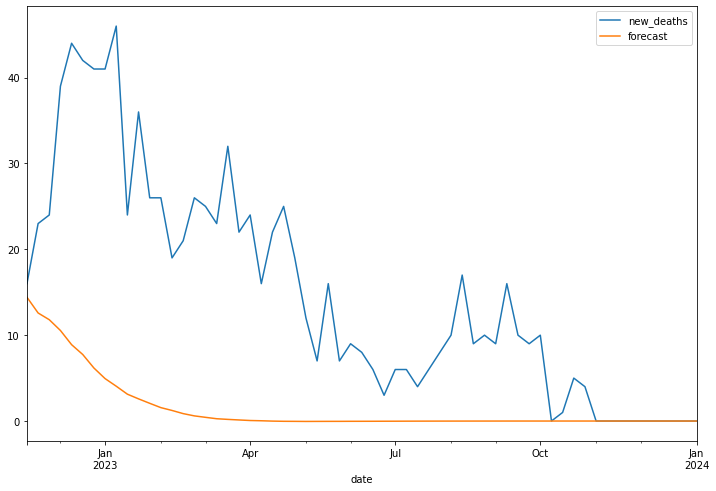

In [272]:
model=sm.tsa.statespace.SARIMAX(israel_train['new_deaths'],order=(2, 0, 1),seasonal_order=(1,0,1,4))
results=model.fit()
israel_test['forecast']=results.predict(start=141,end=202,dynamic=True)
israel_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [273]:
mae = mean_absolute_error(israel_test['new_deaths'], israel_test['forecast'])
r2 = r2_score(israel_test['new_deaths'], israel_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(israel_test['new_deaths'], israel_test['forecast'], y_train = israel_train['new_deaths'])
new_row = {'country': 'Israel', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [274]:
auto_model = auto_arima(israel_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(israel_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  141
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 4)   Log Likelihood                -644.629
Date:                           Tue, 27 Feb 2024   AIC                           1299.257
Time:                                   18:38:55   BIC                           1314.001
Sample:                               03-01-2020   HQIC                          1305.249
                                    - 11-06-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.5508      4.642      1.842      0.065      -0.547      17.648
ar.L1          1.6183      0.039     41.835

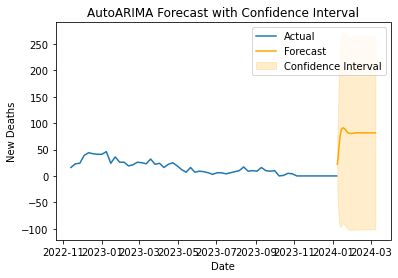

In [275]:
forecast_index = pd.date_range(israel_test.index[-1], periods=n_periods + 1, freq=israel_test.index.freq)[-n_periods:]

plt.plot(israel_test.index, israel_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [276]:
mae = mean_absolute_error(israel_test['new_deaths'], forecast)
r2 = r2_score(israel_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(israel_test['new_deaths'], forecast, y_train = israel_train['new_deaths'])
new_row = {'country': 'Israel', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Italy

## train/test split

In [277]:
italy = pd.read_csv('univariate_df_Italy.csv')
italy = italy.set_index('date')
italy.index = pd.to_datetime(italy.index)
italy = italy.drop('Unnamed: 0', axis=1)
italy.sort_index()
train_size = int(len(italy) * 0.7)
italy_train, italy_test = italy[0:train_size], italy[train_size:]
print(italy_train.shape, italy_test.shape)

(141, 1) (61, 1)


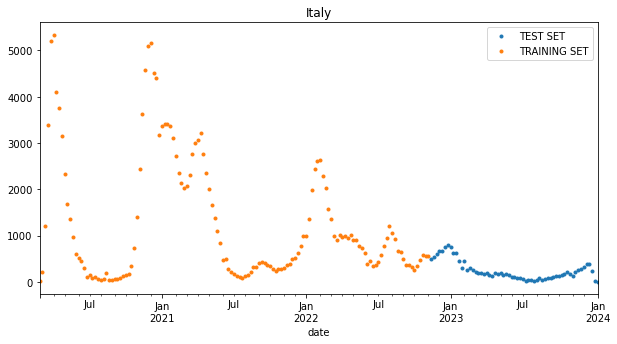

In [278]:
_ = italy_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(italy_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Italy', style='.')

## basic ARIMA (1,0,1)

In [279]:
model=ARIMA(italy_train['new_deaths'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1014.268
Date:                Tue, 27 Feb 2024   AIC                           2036.536
Time:                        18:38:58   BIC                           2048.331
Sample:                    03-01-2020   HQIC                          2041.329
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1273.9344    793.237      1.606      0.108    -280.782    2828.651
ar.L1          0.9275      0.030     31.330      0.000       0.870       0.986
ma.L1          0.5555      0.042     13.356      0.000       0.474       0.637
sigma2      1.014e+05   6760.309     14.993      0.000    8.81e+04    1.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.67   Jarque-Bera (JB):               370.91
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

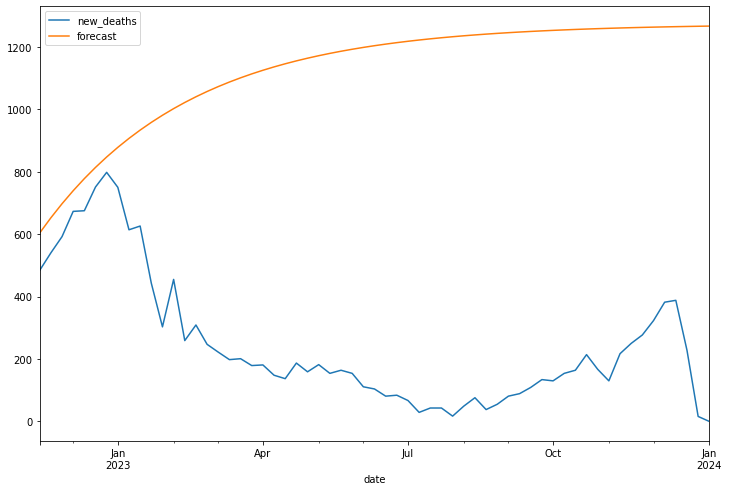

In [280]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [281]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(italy_test['new_deaths'], italy_test['forecast'], y_train = italy_train['new_deaths'])
new_row = {'country': 'Italy', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [282]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(italy_train['new_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
5,2,2,2005.973554
4,2,1,2005.974262
12,4,1,2007.451429
6,2,3,2007.580354
3,1,4,2007.603956
8,3,1,2008.544875
2,1,3,2009.021812
1,1,2,2009.429377
9,3,2,2009.591650
10,3,3,2009.871849


In [283]:
model=ARIMA(italy_train['new_deaths'],order=(2,0,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -996.987
Date:                Tue, 27 Feb 2024   AIC                           2005.974
Time:                        18:39:15   BIC                           2023.666
Sample:                    03-01-2020   HQIC                          2013.163
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1274.0376    552.024      2.308      0.021     192.091    2355.984
ar.L1          1.4091      0.088     16.061      0.000       1.237       1.581
ar.L2         -0.5066      0.084     -6.003      0.000      -0.672      -0.341
ma.L1          0.2702      0.101      2.677      0.007       0.072       0.468
ma.L2          0.1867      0.078      2.384      0.017       0.033       0.340
sigma2      7.898e+04   5732.751     13.776      0.000    6.77e+04    9.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               351.82
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

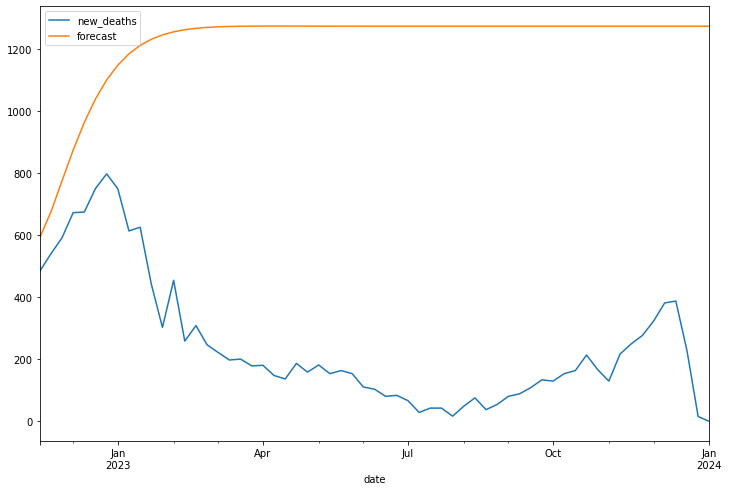

In [284]:
italy_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [285]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(italy_test['new_deaths'], italy_test['forecast'], y_train = italy_train['new_deaths'])
new_row = {'country': 'Italy', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [286]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(p,0,q), seasonal_order=(P,0,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46814D+00    |proj g|=  4.61824D-01

At iterate    5    f=  7.20534D+00    |proj g|=  5.16715D-03


 This problem is unconstrained.



At iterate   10    f=  7.19891D+00    |proj g|=  3.85463D-02

At iterate   15    f=  7.19737D+00    |proj g|=  5.64598D-03

At iterate   20    f=  7.19578D+00    |proj g|=  6.85939D-03

At iterate   25    f=  7.19385D+00    |proj g|=  7.26867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   5.450D-06   7.194D+00
  F =   7.1938504815063089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  7.20132D+00    |proj g|=  6.90094D-03

At iterate   10    f=  7.19852D+00    |proj g|=  2.09384D-02

At iterate   15    f=  7.19536D+00    |proj g|=  2.67721D-03

At iterate   20    f=  7.19440D+00    |proj g|=  5.51494D-03

At iterate   25    f=  7.19258D+00    |proj g|=  4.71849D-03

At iterate   30    f=  7.19218D+00    |proj g|=  1.82578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   2.022D-06   7.192D+00
  F =   7.1921849370940460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   20    f=  7.19473D+00    |proj g|=  3.18760D-03

At iterate   25    f=  7.19381D+00    |proj g|=  8.44341D-03

At iterate   30    f=  7.19238D+00    |proj g|=  1.21525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   3.435D-05   7.192D+00
  F =   7.1923767297620689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  7.57045D+00    |proj g|=  6.56022D-01

At iterate    5    f=  7.20778D+00    |proj g|=  3.00682D-02

At iterate   10    f=  7.20103D+00    |proj g|=  2.27309D-02

At iterate   15    f=  7.19704D+00    |proj g|=  9.29455D-03

At iterate   20    f=  7.19497D+00    |proj g|=  1.84091D-03

At iterate   25    f=  7.19422D+00    |proj g|=  6.63875D-03

At iterate   30    f=  7.19219D+00    |proj g|=  9.48580D-03

At iterate   35    f=  7.19202D+00    |proj g|=  2.03837D-04

At iterate   40    f=  7.19201D+00    |proj g|=  7.71855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     49   

 This problem is unconstrained.



At iterate   10    f=  7.16022D+00    |proj g|=  3.34540D-03

At iterate   15    f=  7.15401D+00    |proj g|=  6.23275D-02

At iterate   20    f=  7.11393D+00    |proj g|=  9.85469D-02

At iterate   25    f=  7.10112D+00    |proj g|=  4.03649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     30      1     0     0   1.740D-05   7.101D+00
  F =   7.1011218941075889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63408D+00    |proj g|=  9.27403D-01

At iterate    5    f=  7.16477D+00    |proj g|=  1.15671D-02

At iterate   10    f=  7.15912D+00    |proj g|=  2.14187D-02

At iterate   15    f=  7.15337D+00    |proj g|=  4.63545D-02

At iterate   20    f=  7.13070D+00    |proj g|=  3.90454D-02

At iterate   25    f=  7.11373D+00    |proj g|=  1.75586D-02

At iterate   30    f=  7.10385D+00    |proj g|=  4.59843D-02

At iterate   35    f=  7.10110D+00    |proj g|=  3.07524D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.16808D+00    |proj g|=  5.76808D-02

At iterate   10    f=  7.16219D+00    |proj g|=  2.14685D-02

At iterate   15    f=  7.15884D+00    |proj g|=  2.13118D-02

At iterate   20    f=  7.14215D+00    |proj g|=  5.04671D-02

At iterate   25    f=  7.10118D+00    |proj g|=  5.17332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   4.512D-06   7.101D+00
  F =   7.1011008126189950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  7.17278D+00    |proj g|=  3.52349D-02

At iterate   10    f=  7.16276D+00    |proj g|=  2.50292D-02

At iterate   15    f=  7.15086D+00    |proj g|=  1.97624D-02

At iterate   20    f=  7.13591D+00    |proj g|=  1.22422D-02

At iterate   25    f=  7.10163D+00    |proj g|=  3.07304D-02

At iterate   30    f=  7.10086D+00    |proj g|=  4.49237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     33      1     0     0   4.492D-05   7.101D+00
  F =   7.1008609481937297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  7.11876D+00    |proj g|=  9.90562D-03

At iterate   15    f=  7.11777D+00    |proj g|=  2.65956D-03

At iterate   20    f=  7.11140D+00    |proj g|=  1.06018D-01

At iterate   25    f=  7.10386D+00    |proj g|=  3.29603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   1.619D-04   7.104D+00
  F =   7.1038543422408971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  7.11911D+00    |proj g|=  1.61671D-02

At iterate   15    f=  7.11815D+00    |proj g|=  2.11671D-03

At iterate   20    f=  7.11704D+00    |proj g|=  8.86711D-03

At iterate   25    f=  7.11129D+00    |proj g|=  4.47173D-02

At iterate   30    f=  7.10382D+00    |proj g|=  8.24384D-03

At iterate   35    f=  7.10366D+00    |proj g|=  1.87631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     40      1     0     0   1.876D-04   7.104D+00
  F =   7.1036578926611647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  7.11931D+00    |proj g|=  1.28981D-02

At iterate   15    f=  7.11819D+00    |proj g|=  4.68588D-03

At iterate   20    f=  7.11665D+00    |proj g|=  1.91554D-02

At iterate   25    f=  7.10736D+00    |proj g|=  2.48882D-02

At iterate   30    f=  7.10378D+00    |proj g|=  1.15889D-03

At iterate   35    f=  7.10378D+00    |proj g|=  5.77884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     52      1     0     0   5.779D-05   7.104D+00
  F =   7.1037826530222405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   15    f=  7.11804D+00    |proj g|=  1.15020D-03

At iterate   20    f=  7.11767D+00    |proj g|=  1.95914D-02

At iterate   25    f=  7.11728D+00    |proj g|=  3.08210D-03

At iterate   30    f=  7.11422D+00    |proj g|=  5.62768D-03

At iterate   35    f=  7.10191D+00    |proj g|=  1.34776D-02

At iterate   40    f=  7.09884D+00    |proj g|=  9.01732D-03

At iterate   45    f=  7.09841D+00    |proj g|=  6.93830D-04

At iterate   50    f=  7.09840D+00    |proj g|=  2.47542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   2.475D-04   7.098D+00
  F =   7.09839638033

 This problem is unconstrained.



At iterate    5    f=  7.21319D+00    |proj g|=  1.74969D-02

At iterate   10    f=  7.20683D+00    |proj g|=  3.24509D-02

At iterate   15    f=  7.20454D+00    |proj g|=  1.06096D-02

At iterate   20    f=  7.11400D+00    |proj g|=  1.51963D-01

At iterate   25    f=  7.09438D+00    |proj g|=  1.33841D-02

At iterate   30    f=  7.09304D+00    |proj g|=  2.67739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     45      1     0     0   1.414D-04   7.093D+00
  F =   7.0930440398053722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  7.21404D+00    |proj g|=  2.63083D-02

At iterate   10    f=  7.20902D+00    |proj g|=  6.62298D-03

At iterate   15    f=  7.20490D+00    |proj g|=  2.57374D-02

At iterate   20    f=  7.20362D+00    |proj g|=  2.52000D-02

At iterate   25    f=  7.18631D+00    |proj g|=  4.50711D-02

At iterate   30    f=  7.11488D+00    |proj g|=  1.26819D-02

At iterate   35    f=  7.11422D+00    |proj g|=  1.07714D-02

At iterate   40    f=  7.09776D+00    |proj g|=  4.82475D-02

At iterate   45    f=  7.09208D+00    |proj g|=  1.66346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     55   

 This problem is unconstrained.



At iterate   10    f=  7.20949D+00    |proj g|=  1.70669D-02

At iterate   15    f=  7.20591D+00    |proj g|=  4.92661D-02

At iterate   20    f=  7.20464D+00    |proj g|=  9.82849D-03

At iterate   25    f=  7.14166D+00    |proj g|=  1.21223D-01

At iterate   30    f=  7.09277D+00    |proj g|=  5.96415D-03

At iterate   35    f=  7.09215D+00    |proj g|=  4.59024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     42      1     0     0   1.241D-05   7.092D+00
  F =   7.0921284376180784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  7.21074D+00    |proj g|=  2.86763D-02

At iterate   15    f=  7.20754D+00    |proj g|=  3.44364D-02

At iterate   20    f=  7.20387D+00    |proj g|=  3.94158D-03

At iterate   25    f=  7.20282D+00    |proj g|=  2.25896D-02

At iterate   30    f=  7.16815D+00    |proj g|=  1.50587D-01

At iterate   35    f=  7.12750D+00    |proj g|=  7.56920D-02

At iterate   40    f=  7.09479D+00    |proj g|=  1.03935D-02

At iterate   45    f=  7.09355D+00    |proj g|=  6.76080D-03

At iterate   50    f=  7.09315D+00    |proj g|=  4.21186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

In [287]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
12,2,2,1,1,2014.238419
4,1,2,1,1,2014.516374
8,2,1,1,1,2015.286925
13,2,2,1,2,2015.967554
14,2,2,2,1,2015.980219
5,1,2,1,2,2016.510263
6,1,2,2,1,2016.510429
9,2,1,1,2,2017.231526
10,2,1,2,1,2017.266708
11,2,1,2,2,2017.747779


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63897D+00    |proj g|=  9.94347D-01

At iterate    5    f=  7.21319D+00    |proj g|=  1.74969D-02


 This problem is unconstrained.



At iterate   10    f=  7.20683D+00    |proj g|=  3.24509D-02

At iterate   15    f=  7.20454D+00    |proj g|=  1.06096D-02

At iterate   20    f=  7.11400D+00    |proj g|=  1.51963D-01

At iterate   25    f=  7.09438D+00    |proj g|=  1.33841D-02

At iterate   30    f=  7.09304D+00    |proj g|=  2.67739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     45      1     0     0   1.414D-04   7.093D+00
  F =   7.0930440398053722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<AxesSubplot:xlabel='date'>

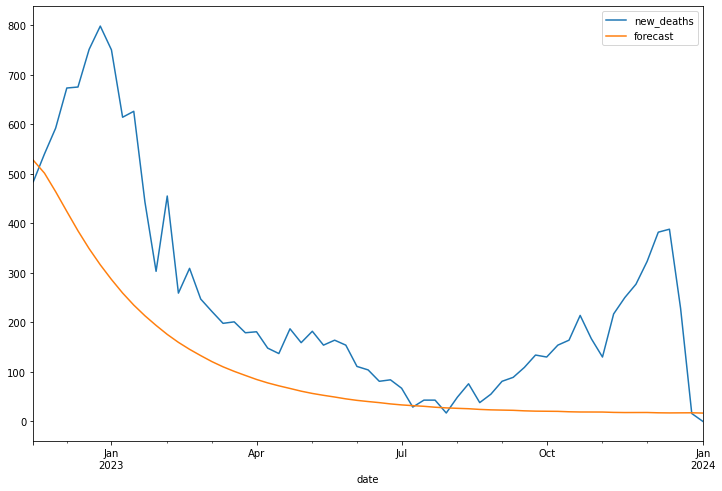

In [288]:
model=sm.tsa.statespace.SARIMAX(italy_train['new_deaths'],order=(2, 0, 2),seasonal_order=(1,0,1,4))
results=model.fit()
italy_test['forecast']=results.predict(start=141,end=202,dynamic=True)
italy_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [289]:
mae = mean_absolute_error(italy_test['new_deaths'], italy_test['forecast'])
r2 = r2_score(italy_test['new_deaths'], italy_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(italy_test['new_deaths'], italy_test['forecast'], y_train = italy_train['new_deaths'])
new_row = {'country': 'Italy', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [290]:
auto_model = auto_arima(italy_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(italy_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -998.306
Date:                Tue, 27 Feb 2024   AIC                           2004.613
Time:                        18:39:49   BIC                           2016.408
Sample:                    03-01-2020   HQIC                          2009.406
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    100.4555     58.548      1.716      0.086     -14.296     215.207
ar.L1          1.6147      0.035     45.694      0.000       1.545       1.684
ar.L2         -0.6948      0.028    -25.057      0.0

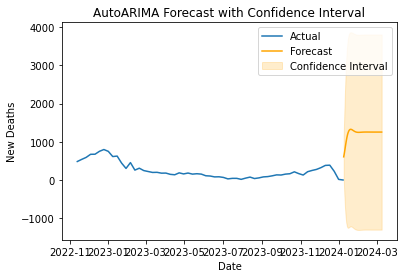

In [291]:
forecast_index = pd.date_range(italy_test.index[-1], periods=n_periods + 1, freq=italy_test.index.freq)[-n_periods:]

plt.plot(italy_test.index, italy_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [292]:
mae = mean_absolute_error(italy_test['new_deaths'], forecast)
r2 = r2_score(italy_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(italy_test['new_deaths'], forecast, y_train = italy_train['new_deaths'])
new_row = {'country': 'Italy', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# United States

## train/test split

In [293]:
us = pd.read_csv('univariate_df_United_States.csv')
us = us.set_index('date')
us.index = pd.to_datetime(us.index)
us = us.drop('Unnamed: 0', axis=1)
us = us.drop('diff1', axis=1)
us.sort_index()
train_size = int(len(us) * 0.7)
us_train, us_test = us[0:train_size], us[train_size:]
print(us_train.shape, us_test.shape)

(141, 1) (61, 1)


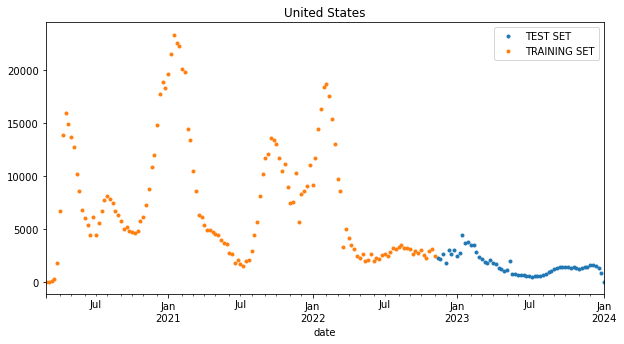

In [294]:
_ = us_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(us_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='United States', style='.')

## basic ARIMA (1,1,1)

In [295]:
model=ARIMA(us_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1217.761
Date:                Tue, 27 Feb 2024   AIC                           2441.522
Time:                        18:39:51   BIC                           2450.347
Sample:                    03-01-2020   HQIC                          2445.108
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7216      0.107      6.717      0.000       0.511       0.932
ma.L1         -0.3930      0.129     -3.046      0.002      -0.646      -0.140
sigma2      2.167e+06   1.63e+05     13.286      0.000    1.85e+06    2.49e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                78.03
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.07
Prob(H) (two-sided):                  0.33   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

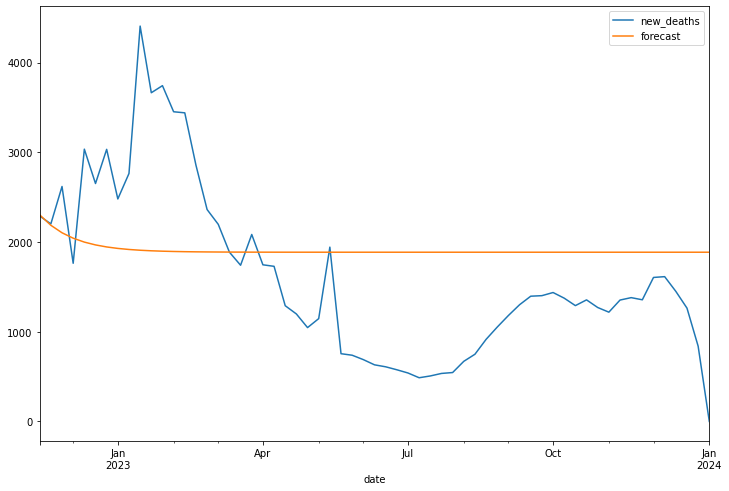

In [296]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [297]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(us_test['new_deaths'], us_test['forecast'], y_train = us_train['new_deaths'])
new_row = {'country': 'US', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [298]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(us_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
8,3,1,2430.672250
9,3,2,2431.981093
12,4,1,2432.044905
10,3,3,2433.653184
7,2,4,2433.781745
13,4,2,2434.676250
6,2,3,2436.275722
5,2,2,2436.461457
1,1,2,2436.975261
4,2,1,2437.961302


In [299]:
model=ARIMA(us_train['new_deaths'],order=(3,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1210.336
Date:                Tue, 27 Feb 2024   AIC                           2430.672
Time:                        18:40:05   BIC                           2445.380
Sample:                    03-01-2020   HQIC                          2436.649
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2003      0.046     26.272      0.000       1.111       1.290
ar.L2          0.0869      0.081      1.080      0.280      -0.071       0.245
ar.L3         -0.3600      0.053     -6.773      0.000      -0.464      -0.256
ma.L1         -1.0000      0.078    -12.743      0.000      -1.154      -0.846
sigma2      1.853e+06   4.24e-08   4.37e+13      0.000    1.85e+06    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                66.86
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.20
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

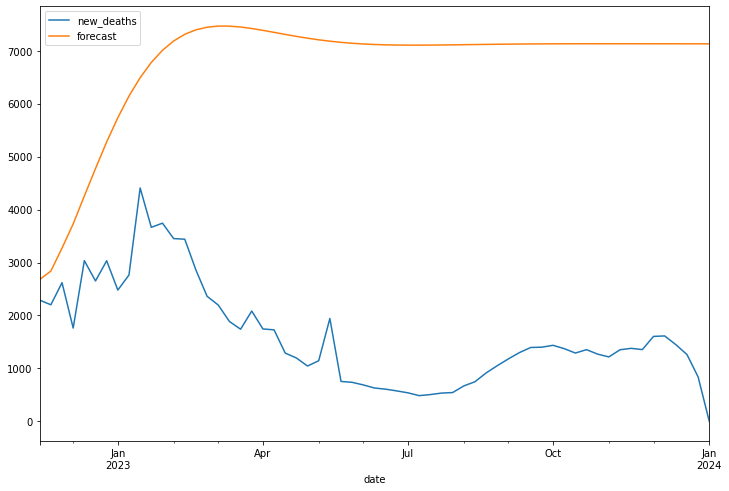

In [300]:
us_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [301]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(us_test['new_deaths'], us_test['forecast'], y_train = us_train['new_deaths'])
new_row = {'country': 'US', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [302]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60833D+00    |proj g|=  2.04759D-01

At iterate    5    f=  8.48710D+00    |proj g|=  1.94856D-02



 This problem is unconstrained.


At iterate   10    f=  8.48063D+00    |proj g|=  1.04762D-03

At iterate   15    f=  8.48059D+00    |proj g|=  4.57616D-04

At iterate   20    f=  8.48043D+00    |proj g|=  7.35647D-03

At iterate   25    f=  8.40810D+00    |proj g|=  1.63692D-02

At iterate   30    f=  8.40763D+00    |proj g|=  7.98366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   1.338D-06   8.408D+00
  F =   8.4076286702815377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate   10    f=  8.47894D+00    |proj g|=  9.68954D-04

At iterate   15    f=  8.47857D+00    |proj g|=  2.63925D-03

At iterate   20    f=  8.47850D+00    |proj g|=  1.79661D-03

At iterate   25    f=  8.47847D+00    |proj g|=  1.38109D-03

At iterate   30    f=  8.47644D+00    |proj g|=  1.94376D-02

At iterate   35    f=  8.43181D+00    |proj g|=  9.45700D-02

At iterate   40    f=  8.40945D+00    |proj g|=  3.66093D-03

At iterate   45    f=  8.40611D+00    |proj g|=  2.99245D-03

At iterate   50    f=  8.40555D+00    |proj g|=  1.49858D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60   

 This problem is unconstrained.



At iterate    5    f=  8.50456D+00    |proj g|=  7.32763D-02

At iterate   10    f=  8.48017D+00    |proj g|=  1.45415D-03

At iterate   15    f=  8.47997D+00    |proj g|=  4.03069D-04

At iterate   20    f=  8.47984D+00    |proj g|=  3.21039D-03

At iterate   25    f=  8.47581D+00    |proj g|=  3.00297D-02

At iterate   30    f=  8.40963D+00    |proj g|=  1.40064D-02

At iterate   35    f=  8.40636D+00    |proj g|=  2.40183D-03

At iterate   40    f=  8.40592D+00    |proj g|=  1.00429D-03

At iterate   45    f=  8.40588D+00    |proj g|=  4.16616D-04

At iterate   50    f=  8.40588D+00    |proj g|=  3.21575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.48213D+00    |proj g|=  2.86292D-02

At iterate   10    f=  8.47874D+00    |proj g|=  1.13297D-03

At iterate   15    f=  8.47859D+00    |proj g|=  3.65750D-03

At iterate   20    f=  8.47843D+00    |proj g|=  2.74106D-04

At iterate   25    f=  8.47841D+00    |proj g|=  1.36215D-03

At iterate   30    f=  8.47717D+00    |proj g|=  1.34875D-02

At iterate   35    f=  8.45580D+00    |proj g|=  7.50779D-02

At iterate   40    f=  8.41071D+00    |proj g|=  8.87793D-03

At iterate   45    f=  8.40808D+00    |proj g|=  1.81731D-03

At iterate   50    f=  8.40774D+00    |proj g|=  1.45267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.40996D+00    |proj g|=  1.54760D-02

At iterate   15    f=  8.40938D+00    |proj g|=  6.17288D-03

At iterate   20    f=  8.40933D+00    |proj g|=  1.84539D-04

At iterate   25    f=  8.40932D+00    |proj g|=  2.26885D-03

At iterate   30    f=  8.40844D+00    |proj g|=  2.51512D-02

At iterate   35    f=  8.39013D+00    |proj g|=  1.00751D-01

At iterate   40    f=  8.37419D+00    |proj g|=  8.03131D-03

At iterate   45    f=  8.37410D+00    |proj g|=  6.85990D-04

At iterate   50    f=  8.37399D+00    |proj g|=  2.68833D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.



At iterate   15    f=  8.40752D+00    |proj g|=  9.15529D-03

At iterate   20    f=  8.40714D+00    |proj g|=  4.02869D-03

At iterate   25    f=  8.40692D+00    |proj g|=  5.94379D-04

At iterate   30    f=  8.40691D+00    |proj g|=  5.37206D-04

At iterate   35    f=  8.40679D+00    |proj g|=  3.51000D-03

At iterate   40    f=  8.37878D+00    |proj g|=  1.08386D-01

At iterate   45    f=  8.37388D+00    |proj g|=  2.96131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     52      1     0     0   6.115D-06   8.374D+00
  F =   8.3738829376447850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.44430D+00    |proj g|=  1.50012D-01

At iterate   10    f=  8.41335D+00    |proj g|=  4.08759D-02

At iterate   15    f=  8.40937D+00    |proj g|=  2.07358D-03

At iterate   20    f=  8.40921D+00    |proj g|=  4.02192D-04

At iterate   25    f=  8.40921D+00    |proj g|=  8.62829D-04

At iterate   30    f=  8.40883D+00    |proj g|=  1.12685D-02

At iterate   35    f=  8.39039D+00    |proj g|=  1.24600D-01

At iterate   40    f=  8.37356D+00    |proj g|=  1.89661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     45      1     0     0   2.512D-05   8.374D+00
  F =   8.37355679407

 This problem is unconstrained.



At iterate   10    f=  8.40605D+00    |proj g|=  8.06541D-03

At iterate   15    f=  8.40595D+00    |proj g|=  2.66375D-03

At iterate   20    f=  8.40583D+00    |proj g|=  6.00123D-03

At iterate   25    f=  8.40576D+00    |proj g|=  1.88380D-04

At iterate   30    f=  8.40575D+00    |proj g|=  1.50764D-03

At iterate   35    f=  8.40035D+00    |proj g|=  6.34995D-02

At iterate   40    f=  8.38426D+00    |proj g|=  3.22622D-02

At iterate   45    f=  8.37445D+00    |proj g|=  1.81558D-03

At iterate   50    f=  8.37444D+00    |proj g|=  1.19906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55   

 This problem is unconstrained.



At iterate    5    f=  8.47011D+00    |proj g|=  2.85398D-02

At iterate   10    f=  8.45690D+00    |proj g|=  2.16395D-03

At iterate   15    f=  8.45675D+00    |proj g|=  2.28331D-04

At iterate   20    f=  8.45627D+00    |proj g|=  6.43215D-03

At iterate   25    f=  8.42550D+00    |proj g|=  5.89835D-02

At iterate   30    f=  8.38067D+00    |proj g|=  1.29313D-02

At iterate   35    f=  8.38011D+00    |proj g|=  4.00239D-04

At iterate   40    f=  8.37994D+00    |proj g|=  6.36201D-03

At iterate   45    f=  8.37972D+00    |proj g|=  1.70427D-03

At iterate   50    f=  8.37969D+00    |proj g|=  1.55548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.45681D+00    |proj g|=  2.27217D-02

At iterate   10    f=  8.45429D+00    |proj g|=  9.28946D-04

At iterate   15    f=  8.45404D+00    |proj g|=  1.76810D-03

At iterate   20    f=  8.45396D+00    |proj g|=  5.29964D-04

At iterate   25    f=  8.45391D+00    |proj g|=  3.34374D-03

At iterate   30    f=  8.43971D+00    |proj g|=  7.88649D-02

At iterate   35    f=  8.38615D+00    |proj g|=  7.15806D-02

At iterate   40    f=  8.36186D+00    |proj g|=  6.01899D-02

At iterate   45    f=  8.35767D+00    |proj g|=  7.47589D-04

At iterate   50    f=  8.35735D+00    |proj g|=  6.65306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.45703D+00    |proj g|=  7.81197D-03

At iterate   15    f=  8.45673D+00    |proj g|=  4.97100D-04

At iterate   20    f=  8.45672D+00    |proj g|=  3.34619D-04

At iterate   25    f=  8.45605D+00    |proj g|=  2.00330D-02

At iterate   30    f=  8.41055D+00    |proj g|=  1.32369D-01

At iterate   35    f=  8.38244D+00    |proj g|=  9.89002D-03

At iterate   40    f=  8.38088D+00    |proj g|=  7.66741D-03

At iterate   45    f=  8.37968D+00    |proj g|=  4.76226D-03

At iterate   50    f=  8.37948D+00    |proj g|=  4.64857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

 This problem is unconstrained.



At iterate    5    f=  8.45760D+00    |proj g|=  2.48348D-02

At iterate   10    f=  8.45414D+00    |proj g|=  1.15625D-03

At iterate   15    f=  8.45405D+00    |proj g|=  1.47975D-03

At iterate   20    f=  8.45394D+00    |proj g|=  8.76278D-04

At iterate   25    f=  8.45392D+00    |proj g|=  9.95580D-04

At iterate   30    f=  8.45321D+00    |proj g|=  4.89568D-03

At iterate   35    f=  8.41883D+00    |proj g|=  1.10270D-01

At iterate   40    f=  8.38004D+00    |proj g|=  1.72789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     53      1     0     0   4.347D-06   8.380D+00
  F =   8.37971930008

 This problem is unconstrained.



At iterate    5    f=  8.42384D+00    |proj g|=  9.35727D-02

At iterate   10    f=  8.40954D+00    |proj g|=  1.84974D-02

At iterate   15    f=  8.40862D+00    |proj g|=  1.43162D-03

At iterate   20    f=  8.40862D+00    |proj g|=  2.99225D-04

At iterate   25    f=  8.40860D+00    |proj g|=  1.22219D-03

At iterate   30    f=  8.40855D+00    |proj g|=  4.91380D-03

At iterate   35    f=  8.40511D+00    |proj g|=  2.98967D-02

At iterate   40    f=  8.37434D+00    |proj g|=  2.40781D-02

At iterate   45    f=  8.37320D+00    |proj g|=  1.35521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     52   

 This problem is unconstrained.



At iterate    5    f=  8.41246D+00    |proj g|=  4.45974D-02

At iterate   10    f=  8.40701D+00    |proj g|=  3.05144D-03

At iterate   15    f=  8.40686D+00    |proj g|=  2.61711D-03

At iterate   20    f=  8.40642D+00    |proj g|=  3.72023D-03

At iterate   25    f=  8.40621D+00    |proj g|=  2.06996D-04

At iterate   30    f=  8.40617D+00    |proj g|=  1.27918D-03

At iterate   35    f=  8.40614D+00    |proj g|=  3.81786D-04

At iterate   40    f=  8.40564D+00    |proj g|=  6.30698D-03

At iterate   45    f=  8.37999D+00    |proj g|=  6.60257D-02

At iterate   50    f=  8.37479D+00    |proj g|=  2.46980D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.44376D+00    |proj g|=  1.71136D-01

At iterate   10    f=  8.41112D+00    |proj g|=  2.60888D-02

At iterate   15    f=  8.40861D+00    |proj g|=  3.88802D-03

At iterate   20    f=  8.40846D+00    |proj g|=  1.83853D-04

At iterate   25    f=  8.40845D+00    |proj g|=  1.03244D-03

At iterate   30    f=  8.40807D+00    |proj g|=  1.02290D-02

At iterate   35    f=  8.40744D+00    |proj g|=  3.78710D-03

At iterate   40    f=  8.40728D+00    |proj g|=  6.04751D-03

At iterate   45    f=  8.39693D+00    |proj g|=  1.22945D-01

At iterate   50    f=  8.38233D+00    |proj g|=  2.14417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.41120D+00    |proj g|=  7.27497D-02

At iterate   10    f=  8.40529D+00    |proj g|=  7.37827D-03

At iterate   15    f=  8.40522D+00    |proj g|=  1.52729D-03

At iterate   20    f=  8.40511D+00    |proj g|=  1.33924D-03

At iterate   25    f=  8.40507D+00    |proj g|=  8.35203D-04

At iterate   30    f=  8.40504D+00    |proj g|=  1.41792D-03

At iterate   35    f=  8.40503D+00    |proj g|=  2.83215D-04

At iterate   40    f=  8.40502D+00    |proj g|=  8.10387D-04

At iterate   45    f=  8.40494D+00    |proj g|=  6.01432D-03

At iterate   50    f=  8.40255D+00    |proj g|=  2.17955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [303]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
9,2,1,1,2,2370.772468
4,1,2,1,1,2373.464975
8,2,1,1,1,2375.072366
12,2,2,1,1,2375.242248
6,1,2,2,1,2375.343016
5,1,2,1,2,2375.434988
10,2,1,2,1,2377.012058
7,1,2,2,2,2377.591261
13,2,2,1,2,2377.690562
11,2,1,2,2,2379.080843


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54022D+00    |proj g|=  2.48213D-01

At iterate    5    f=  8.45681D+00    |proj g|=  2.27217D-02

At iterate   10    f=  8.45429D+00    |proj g|=  9.28946D-04

At iterate   15    f=  8.45404D+00    |proj g|=  1.76810D-03

At iterate   20    f=  8.45396D+00    |proj g|=  5.29964D-04

At iterate   25    f=  8.45391D+00    |proj g|=  3.34374D-03

At iterate   30    f=  8.43971D+00    |proj g|=  7.88649D-02

At iterate   35    f=  8.38615D+00    |proj g|=  7.15806D-02

At iterate   40    f=  8.36186D+00    |proj g|=  6.01899D-02

At iterate   45    f=  8.35767D+00    |proj g|=  7.47589D-04

At iterate   50    f=  8.35735D+00    |proj g|=  6.65306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<AxesSubplot:xlabel='date'>

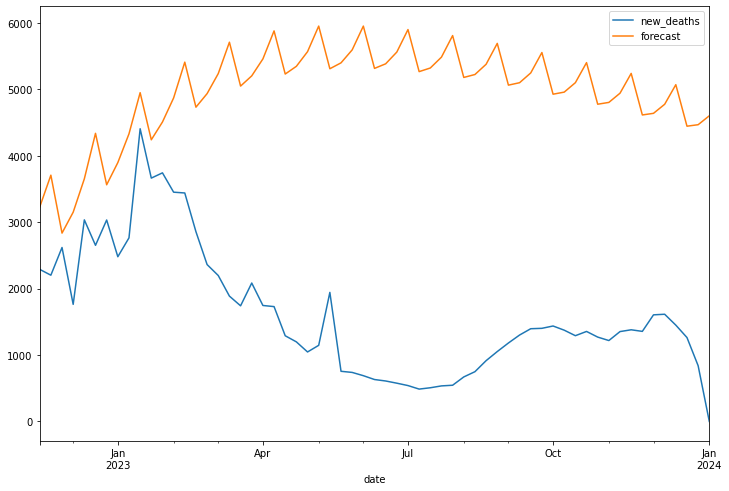

In [304]:
model=sm.tsa.statespace.SARIMAX(us_train['new_deaths'],order=(2, 1, 1),seasonal_order=(1,1,2,4))
results=model.fit()
us_test['forecast']=results.predict(start=141,end=202,dynamic=True)
us_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [305]:
mae = mean_absolute_error(us_test['new_deaths'], us_test['forecast'])
r2 = r2_score(us_test['new_deaths'], us_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(us_test['new_deaths'], us_test['forecast'], y_train = us_train['new_deaths'])
new_row = {'country': 'US', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [306]:
auto_model = auto_arima(us_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(us_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1218.307
Date:                Tue, 27 Feb 2024   AIC                           2448.615
Time:                        18:40:40   BIC                           2466.308
Sample:                    03-01-2020   HQIC                          2455.805
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    512.5092    157.772      3.248      0.001     203.282     821.737
ar.L1          1.6825      0.092     18.379      0.000       1.503       1.862
ar.L2         -0.7485      0.086     -8.746      0.0

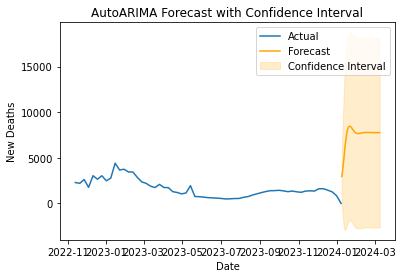

In [307]:
forecast_index = pd.date_range(us_test.index[-1], periods=n_periods + 1, freq=us_test.index.freq)[-n_periods:]

plt.plot(us_test.index, us_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [308]:
mae = mean_absolute_error(us_test['new_deaths'], forecast)
r2 = r2_score(us_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(us_test['new_deaths'], forecast, y_train = us_train['new_deaths'])
new_row = {'country': 'US', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Czechia

## train/test split

In [309]:
czechia = pd.read_csv('univariate_df_Czechia.csv')
czechia = czechia.set_index('date')
czechia.index = pd.to_datetime(czechia.index)
czechia = czechia.drop('Unnamed: 0', axis=1)
czechia = czechia.drop('diff1', axis=1)
czechia.sort_index()
train_size = int(len(czechia) * 0.7)
czechia_train, czechia_test = czechia[0:train_size], czechia[train_size:]
print(czechia_train.shape, czechia_test.shape)

(141, 1) (61, 1)


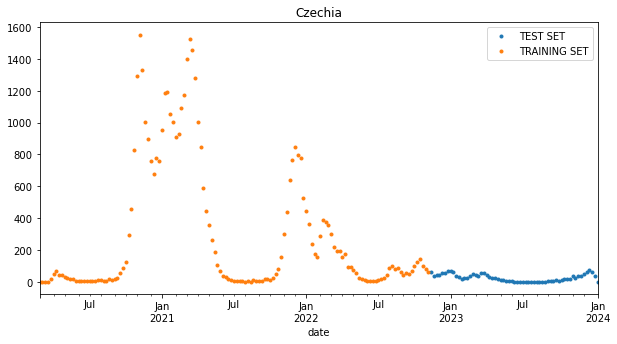

In [310]:
_ = czechia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(czechia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Czechia', style='.')

## basic ARIMA (1,1,1)

In [311]:
model=ARIMA(czechia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -800.674
Date:                Tue, 27 Feb 2024   AIC                           1607.348
Time:                        18:40:43   BIC                           1616.172
Sample:                    03-01-2020   HQIC                          1610.934
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5081      0.054      9.401      0.000       0.402       0.614
ma.L1          0.2949      0.064      4.614      0.000       0.170       0.420
sigma2      5407.8074    339.456     15.931      0.000    4742.486    6073.128
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               175.52
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

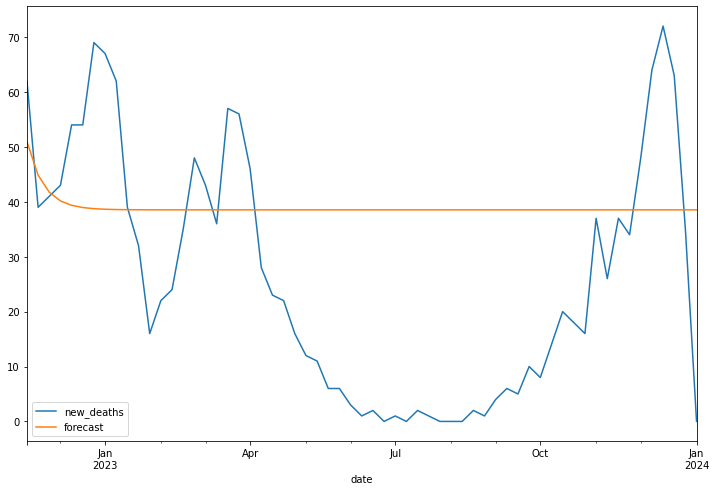

In [312]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [313]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(czechia_test['new_deaths'], czechia_test['forecast'], y_train = czechia_train['new_deaths'])
new_row = {'country': 'Czechia', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [314]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(czechia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
6,2,3,1601.155974
10,3,3,1602.201856
4,2,1,1602.231170
7,2,4,1602.572989
12,4,1,1603.636664
5,2,2,1604.032261
11,3,4,1604.062748
3,1,4,1604.072284
8,3,1,1604.130403
14,4,3,1605.057628


In [315]:
model=ARIMA(czechia_train['new_deaths'],order=(2,1,3))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -794.578
Date:                Tue, 27 Feb 2024   AIC                           1601.156
Time:                        18:40:55   BIC                           1618.806
Sample:                    03-01-2020   HQIC                          1608.328
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4172      0.068     20.869      0.000       1.284       1.550
ar.L2         -0.8575      0.052    -16.454      0.000      -0.960      -0.755
ma.L1         -0.6873      0.080     -8.639      0.000      -0.843      -0.531
ma.L2          0.1716      0.078      2.203      0.028       0.019       0.324
ma.L3          0.3733      0.076      4.909      0.000       0.224       0.522
sigma2      4938.4666    337.631     14.627      0.000    4276.721    5600.212
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               203.33
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

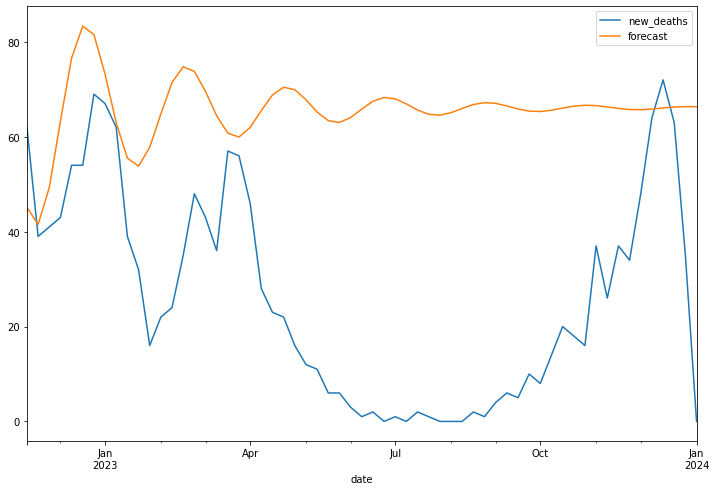

In [316]:
czechia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [317]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(czechia_test['new_deaths'], czechia_test['forecast'], y_train = czechia_train['new_deaths'])
new_row = {'country': 'Czechia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [318]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79300D+00    |proj g|=  1.01552D-01


 This problem is unconstrained.



At iterate    5    f=  5.72421D+00    |proj g|=  5.18480D-03

At iterate   10    f=  5.61551D+00    |proj g|=  1.19712D-01

At iterate   15    f=  5.55055D+00    |proj g|=  2.08811D-02

At iterate   20    f=  5.55020D+00    |proj g|=  2.11386D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   2.114D-06   5.550D+00
  F =   5.5502003104431150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.72830D+00    |proj g|=  3.59988D-02

At iterate   10    f=  5.71979D+00    |proj g|=  1.40002D-02

At iterate   15    f=  5.65967D+00    |proj g|=  1.23698D-02

At iterate   20    f=  5.57957D+00    |proj g|=  4.50417D-02

At iterate   25    f=  5.54857D+00    |proj g|=  2.34625D-02

At iterate   30    f=  5.54391D+00    |proj g|=  1.06876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   6.605D-06   5.544D+00
  F =   5.5438988643223031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.72419D+00    |proj g|=  1.26049D-02

At iterate   10    f=  5.72029D+00    |proj g|=  6.24414D-03

At iterate   15    f=  5.58589D+00    |proj g|=  1.85532D-01

At iterate   20    f=  5.54460D+00    |proj g|=  6.40129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   6.766D-06   5.545D+00
  F =   5.5445344834587829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.72388D+00    |proj g|=  5.63971D-03

At iterate   10    f=  5.72116D+00    |proj g|=  1.09311D-02

At iterate   15    f=  5.60090D+00    |proj g|=  1.22213D-01

At iterate   20    f=  5.55029D+00    |proj g|=  2.53081D-02

At iterate   25    f=  5.54968D+00    |proj g|=  6.19100D-05

At iterate   30    f=  5.54967D+00    |proj g|=  2.27085D-03

At iterate   35    f=  5.54955D+00    |proj g|=  1.22172D-03

At iterate   40    f=  5.54939D+00    |proj g|=  1.29914D-03

At iterate   45    f=  5.54933D+00    |proj g|=  3.67687D-04

At iterate   50    f=  5.54931D+00    |proj g|=  1.88198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.73715D+00    |proj g|=  1.84576D-02

At iterate   10    f=  5.73419D+00    |proj g|=  1.52930D-02

At iterate   15    f=  5.64148D+00    |proj g|=  1.13683D-01

At iterate   20    f=  5.61394D+00    |proj g|=  9.70034D-03

At iterate   25    f=  5.61202D+00    |proj g|=  5.86931D-04

At iterate   30    f=  5.61179D+00    |proj g|=  1.93944D-02
  ys=-1.010E-02  -gs= 1.886E-03 BFGS update SKIPPED

At iterate   35    f=  5.57599D+00    |proj g|=  7.25158D-02

At iterate   40    f=  5.55199D+00    |proj g|=  3.47163D-02

At iterate   45    f=  5.55016D+00    |proj g|=  3.50050D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  5.74115D+00    |proj g|=  1.71204D-02

At iterate   10    f=  5.73626D+00    |proj g|=  8.64668D-03

At iterate   15    f=  5.69085D+00    |proj g|=  1.58696D-02

At iterate   20    f=  5.59928D+00    |proj g|=  6.88447D-02

At iterate   25    f=  5.55635D+00    |proj g|=  3.53624D-02

At iterate   30    f=  5.54785D+00    |proj g|=  1.94192D-03

At iterate   35    f=  5.54772D+00    |proj g|=  8.68690D-03

At iterate   40    f=  5.54447D+00    |proj g|=  1.28831D-02

At iterate   45    f=  5.54392D+00    |proj g|=  9.41926D-04

At iterate   50    f=  5.54377D+00    |proj g|=  1.24731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.74115D+00    |proj g|=  2.01284D-02

At iterate   10    f=  5.73332D+00    |proj g|=  4.97793D-03

At iterate   15    f=  5.70868D+00    |proj g|=  3.09701D-02

At iterate   20    f=  5.60941D+00    |proj g|=  2.37308D-02

At iterate   25    f=  5.60609D+00    |proj g|=  5.60178D-02

At iterate   30    f=  5.59338D+00    |proj g|=  1.18487D-02

At iterate   35    f=  5.59222D+00    |proj g|=  2.14775D-02

At iterate   40    f=  5.55427D+00    |proj g|=  5.86557D-02

At iterate   45    f=  5.54447D+00    |proj g|=  1.25750D-02

At iterate   50    f=  5.54430D+00    |proj g|=  2.94555D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.73738D+00    |proj g|=  5.83417D-03

At iterate   10    f=  5.73415D+00    |proj g|=  7.35257D-03

At iterate   15    f=  5.67842D+00    |proj g|=  4.89630D-02

At iterate   20    f=  5.57550D+00    |proj g|=  8.69573D-02

At iterate   25    f=  5.55003D+00    |proj g|=  8.74695D-03

At iterate   30    f=  5.54976D+00    |proj g|=  1.26204D-03

At iterate   35    f=  5.54970D+00    |proj g|=  3.56243D-03

At iterate   40    f=  5.54953D+00    |proj g|=  4.47674D-03

At iterate   45    f=  5.54938D+00    |proj g|=  7.26232D-03

At iterate   50    f=  5.54930D+00    |proj g|=  2.52669D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.67495D+00    |proj g|=  2.93636D-02

At iterate   10    f=  5.66335D+00    |proj g|=  4.57875D-03

At iterate   15    f=  5.56410D+00    |proj g|=  6.51806D-03

At iterate   20    f=  5.56206D+00    |proj g|=  2.47267D-03

At iterate   25    f=  5.56202D+00    |proj g|=  2.19625D-04

At iterate   30    f=  5.56199D+00    |proj g|=  7.44679D-03

At iterate   35    f=  5.56166D+00    |proj g|=  2.93175D-03

At iterate   40    f=  5.56021D+00    |proj g|=  1.55110D-02

At iterate   45    f=  5.55292D+00    |proj g|=  6.24061D-02

At iterate   50    f=  5.54771D+00    |proj g|=  2.27493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.66914D+00    |proj g|=  7.44594D-03

At iterate   10    f=  5.66198D+00    |proj g|=  9.78401D-03

At iterate   15    f=  5.65314D+00    |proj g|=  1.01784D-02

At iterate   20    f=  5.62266D+00    |proj g|=  4.32910D-02

At iterate   25    f=  5.56233D+00    |proj g|=  3.01309D-02

At iterate   30    f=  5.55889D+00    |proj g|=  2.70651D-03

At iterate   35    f=  5.55558D+00    |proj g|=  2.28140D-03

At iterate   40    f=  5.55506D+00    |proj g|=  5.61932D-03

At iterate   45    f=  5.55487D+00    |proj g|=  1.38237D-04

At iterate   50    f=  5.55485D+00    |proj g|=  6.25734D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.69469D+00    |proj g|=  6.42267D-02

At iterate   10    f=  5.66725D+00    |proj g|=  5.53967D-03

At iterate   15    f=  5.66034D+00    |proj g|=  6.78506D-03

At iterate   20    f=  5.56446D+00    |proj g|=  2.25368D-02

At iterate   25    f=  5.56409D+00    |proj g|=  3.93454D-03

At iterate   30    f=  5.56199D+00    |proj g|=  5.39943D-02

At iterate   35    f=  5.55993D+00    |proj g|=  4.24075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     52      1     0     0   3.457D-06   5.560D+00
  F =   5.5599270055146865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  5.66447D+00    |proj g|=  4.62111D-03

At iterate   15    f=  5.65234D+00    |proj g|=  2.38807D-02

At iterate   20    f=  5.64333D+00    |proj g|=  2.96649D-02

At iterate   25    f=  5.62360D+00    |proj g|=  3.22938D-02

At iterate   30    f=  5.58363D+00    |proj g|=  5.42989D-02

At iterate   35    f=  5.56977D+00    |proj g|=  5.75751D-03

At iterate   40    f=  5.56924D+00    |proj g|=  3.01812D-04

At iterate   45    f=  5.56923D+00    |proj g|=  3.66602D-04

At iterate   50    f=  5.56915D+00    |proj g|=  1.17372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59   

 This problem is unconstrained.



At iterate    5    f=  5.68268D+00    |proj g|=  1.06544D-02

At iterate   10    f=  5.67597D+00    |proj g|=  4.86910D-03

At iterate   15    f=  5.54845D+00    |proj g|=  1.34923D-02

At iterate   20    f=  5.54820D+00    |proj g|=  7.70111D-03

At iterate   25    f=  5.54646D+00    |proj g|=  4.31518D-03

At iterate   30    f=  5.54636D+00    |proj g|=  2.25177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     39      1     0     0   2.250D-05   5.546D+00
  F =   5.5463585505515196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.68275D+00    |proj g|=  9.17399D-03

At iterate   10    f=  5.67745D+00    |proj g|=  6.23872D-03

At iterate   15    f=  5.65167D+00    |proj g|=  9.85145D-02

At iterate   20    f=  5.60154D+00    |proj g|=  4.19590D-02

At iterate   25    f=  5.57545D+00    |proj g|=  1.06965D-01

At iterate   30    f=  5.55110D+00    |proj g|=  3.61186D-03

At iterate   35    f=  5.55021D+00    |proj g|=  5.91738D-03

At iterate   40    f=  5.54997D+00    |proj g|=  2.04168D-03

At iterate   45    f=  5.54996D+00    |proj g|=  1.31594D-04

At iterate   50    f=  5.54995D+00    |proj g|=  2.81622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.70805D+00    |proj g|=  7.05593D-02

At iterate   10    f=  5.67754D+00    |proj g|=  9.43809D-03

At iterate   15    f=  5.67483D+00    |proj g|=  6.84647D-03

At iterate   20    f=  5.61494D+00    |proj g|=  3.35167D-02

At iterate   25    f=  5.55293D+00    |proj g|=  7.96730D-02

At iterate   30    f=  5.54450D+00    |proj g|=  3.62934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     40      1     0     0   1.678D-05   5.544D+00
  F =   5.5444966326251119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.68029D+00    |proj g|=  2.24098D-02

At iterate   10    f=  5.67715D+00    |proj g|=  7.22788D-03

At iterate   15    f=  5.62902D+00    |proj g|=  7.13588D-02

At iterate   20    f=  5.55218D+00    |proj g|=  4.64709D-03

At iterate   25    f=  5.54996D+00    |proj g|=  8.55123D-04

At iterate   30    f=  5.54969D+00    |proj g|=  4.58193D-03

At iterate   35    f=  5.54939D+00    |proj g|=  1.99236D-03

At iterate   40    f=  5.54927D+00    |proj g|=  3.15445D-03

At iterate   45    f=  5.54913D+00    |proj g|=  1.95000D-03

At iterate   50    f=  5.54905D+00    |proj g|=  1.82415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [319]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
0,1,1,1,1,1575.156488
1,1,1,1,2,1575.379480
2,1,1,2,1,1575.558724
8,2,1,1,1,1576.453179
4,1,2,1,1,1577.132909
5,1,2,1,2,1577.343611
6,1,2,2,1,1577.493025
12,2,2,1,1,1578.073111
3,1,1,2,2,1578.905269
14,2,2,2,1,1579.548050


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79300D+00    |proj g|=  1.01552D-01

At iterate    5    f=  5.72421D+00    |proj g|=  5.18480D-03


 This problem is unconstrained.



At iterate   10    f=  5.61551D+00    |proj g|=  1.19712D-01

At iterate   15    f=  5.55055D+00    |proj g|=  2.08811D-02

At iterate   20    f=  5.55020D+00    |proj g|=  2.11386D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   2.114D-06   5.550D+00
  F =   5.5502003104431150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<AxesSubplot:xlabel='date'>

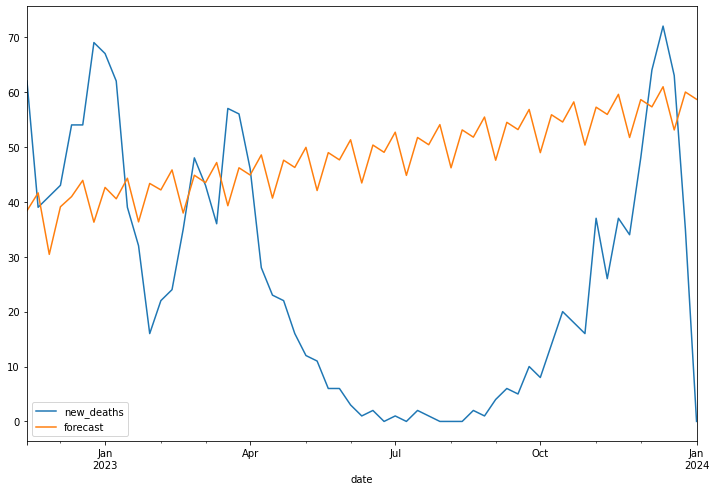

In [320]:
model=sm.tsa.statespace.SARIMAX(czechia_train['new_deaths'],order=(1, 1, 1),seasonal_order=(1,1,1,4))
results=model.fit()
czechia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
czechia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [321]:
mae = mean_absolute_error(czechia_test['new_deaths'], czechia_test['forecast'])
r2 = r2_score(czechia_test['new_deaths'], czechia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(czechia_test['new_deaths'], czechia_test['forecast'], y_train = czechia_train['new_deaths'])
new_row = {'country': 'Czechia', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [322]:
auto_model = auto_arima(czechia_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(czechia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  141
Model:             SARIMAX(3, 0, 0)x(0, 0, [1], 4)   Log Likelihood                -801.555
Date:                             Tue, 27 Feb 2024   AIC                           1615.111
Time:                                     18:41:46   BIC                           1632.803
Sample:                                 03-01-2020   HQIC                          1622.300
                                      - 11-06-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.1157     12.257      0.662      0.508     -15.907      32.138
ar.L1          1.7490      

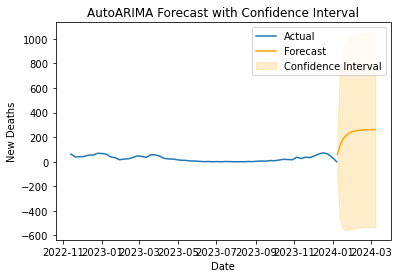

In [323]:
forecast_index = pd.date_range(czechia_test.index[-1], periods=n_periods + 1, freq=czechia_test.index.freq)[-n_periods:]

plt.plot(czechia_test.index, czechia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [324]:
mae = mean_absolute_error(czechia_test['new_deaths'], forecast)
r2 = r2_score(czechia_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(czechia_test['new_deaths'], forecast, y_train = czechia_train['new_deaths'])
new_row = {'country': 'Czechia', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Estonia

## train/test split

In [325]:
estonia = pd.read_csv('univariate_df_Estonia.csv')
estonia = estonia.set_index('date')
estonia.index = pd.to_datetime(estonia.index)
estonia = estonia.drop('Unnamed: 0', axis=1)
estonia = estonia.drop('diff1', axis=1)
estonia.sort_index()
train_size = int(len(estonia) * 0.7)
estonia_train, estonia_test = estonia[0:train_size], estonia[train_size:]
print(estonia_train.shape, estonia_test.shape)

(141, 1) (61, 1)


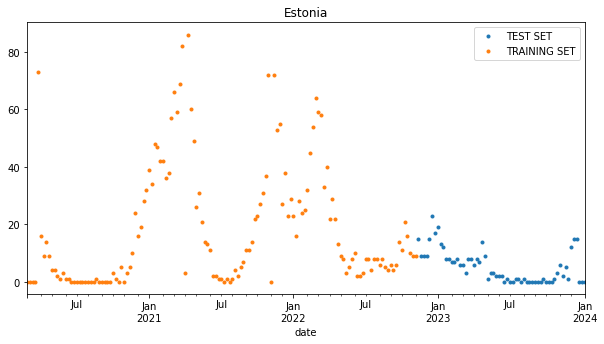

In [326]:
_ = estonia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(estonia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Estonia', style='.')

## basic ARIMA (1,1,1)

In [327]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -566.522
Date:                Tue, 27 Feb 2024   AIC                           1139.044
Time:                        18:41:48   BIC                           1147.869
Sample:                    03-01-2020   HQIC                          1142.630
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3587      0.089     -4.032      0.000      -0.533      -0.184
ma.L1         -0.3083      0.104     -2.963      0.003      -0.512      -0.104
sigma2       190.9689     10.733     17.792      0.000     169.932     212.006
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               542.62
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

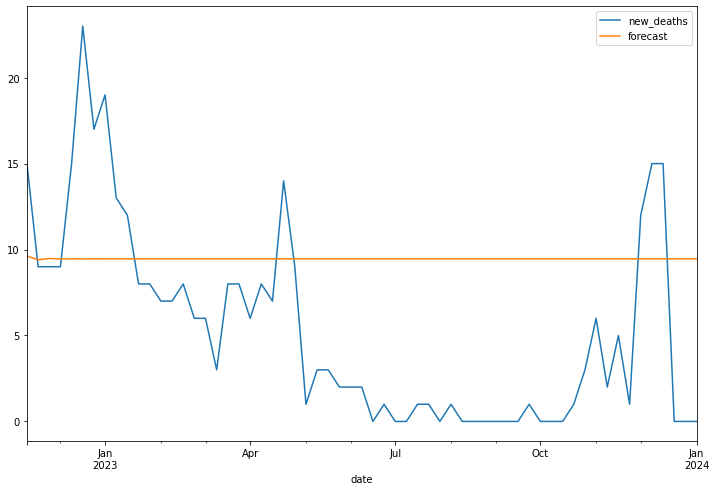

In [328]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [329]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(estonia_test['new_deaths'], estonia_test['forecast'], y_train = estonia_train['new_deaths'])
new_row = {'country': 'Estonia', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [330]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(estonia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
1,1,2,1138.502611
0,1,1,1139.043778
5,2,2,1140.464763
4,2,1,1140.482547
7,2,4,1140.664562
2,1,3,1140.815389
8,3,1,1141.205140
12,4,1,1141.330897
3,1,4,1141.631094
6,2,3,1141.927197


In [331]:
model=ARIMA(estonia_train['new_deaths'],order=(1,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -565.251
Date:                Tue, 27 Feb 2024   AIC                           1138.503
Time:                        18:41:54   BIC                           1150.269
Sample:                    03-01-2020   HQIC                          1143.284
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2369      0.207      1.143      0.253      -0.169       0.643
ma.L1         -0.9234      0.201     -4.599      0.000      -1.317      -0.530
ma.L2          0.4056      0.112      3.613      0.000       0.186       0.626
sigma2       187.3996     10.090     18.572      0.000     167.623     207.176
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               659.67
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

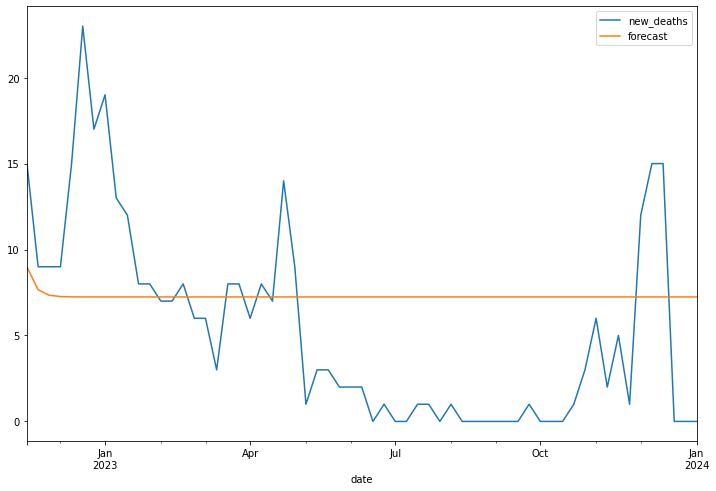

In [332]:
estonia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [333]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(estonia_test['new_deaths'], estonia_test['forecast'], y_train = estonia_train['new_deaths'])
new_row = {'country': 'Estonia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [334]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03214D+00    |proj g|=  9.54682D-02

At iterate    5    f=  3.97497D+00    |proj g|=  1.46540D-02

At iterate   10    f=  3.95382D+00    |proj g|=  6.49957D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.360D-05   3.954D+00
  F =   3.9537692652002643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98292D+00    |proj g|=  2.60505D-02

At iterate    5    f=  3.96448D+00    |proj g|=  1.27711D-02


 This problem is unconstrained.



At iterate   10    f=  3.95356D+00    |proj g|=  8.03802D-03

At iterate   15    f=  3.95063D+00    |proj g|=  4.20515D-04

At iterate   20    f=  3.95062D+00    |proj g|=  1.43354D-03

At iterate   25    f=  3.95058D+00    |proj g|=  4.83929D-04

At iterate   30    f=  3.95058D+00    |proj g|=  1.62679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     39      1     0     0   1.195D-04   3.951D+00
  F =   3.9505786531238449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02158D+00    |proj g|=  4.59758D-02

At iterate    5    f=  3.97259D+00    |proj g|=  1.91725D-02

At iterate   10    f=  3.95097D+00    |proj g|=  1.14577D-02

At iterate   15    f=  3.95086D+00    |proj g|=  1.56555D-04

At iterate   20    f=  3.95084D+00    |proj g|=  4.60498D-03

At iterate   25    f=  3.95078D+00    |proj g|=  2.27830D-04

At iterate   30    f=  3.95078D+00    |proj g|=  1.99546D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  3.95247D+00    |proj g|=  5.75521D-03

At iterate   20    f=  3.95055D+00    |proj g|=  9.55707D-03

At iterate   25    f=  3.95042D+00    |proj g|=  8.27460D-04

At iterate   30    f=  3.95028D+00    |proj g|=  4.26719D-03

At iterate   35    f=  3.95009D+00    |proj g|=  4.66979D-04

At iterate   40    f=  3.95009D+00    |proj g|=  1.12675D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     45      1     0     0   1.127D-05   3.950D+00
  F =   3.9500863743701577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  3.95780D+00    |proj g|=  1.45642D-02

At iterate   15    f=  3.94745D+00    |proj g|=  3.99407D-03

At iterate   20    f=  3.94740D+00    |proj g|=  1.23742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     25      1     0     0   1.237D-05   3.947D+00
  F =   3.9474016141446655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98713D+00    |proj g|=  2.76439D-02


 This problem is unconstrained.



At iterate    5    f=  3.96541D+00    |proj g|=  1.52860D-02

At iterate   10    f=  3.94814D+00    |proj g|=  9.72422D-03

At iterate   15    f=  3.94723D+00    |proj g|=  3.20070D-03

At iterate   20    f=  3.94508D+00    |proj g|=  1.44354D-02

At iterate   25    f=  3.94486D+00    |proj g|=  1.24699D-03

At iterate   30    f=  3.94485D+00    |proj g|=  1.90494D-04

At iterate   35    f=  3.94484D+00    |proj g|=  2.81910D-04

At iterate   40    f=  3.94484D+00    |proj g|=  6.81996D-05

At iterate   45    f=  3.94484D+00    |proj g|=  1.46633D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     53   

 This problem is unconstrained.



At iterate   15    f=  3.94535D+00    |proj g|=  3.15031D-03

At iterate   20    f=  3.94534D+00    |proj g|=  5.40019D-04

At iterate   25    f=  3.94528D+00    |proj g|=  4.70604D-03

At iterate   30    f=  3.94523D+00    |proj g|=  2.18678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     39      1     0     0   4.300D-05   3.945D+00
  F =   3.9452308654433588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  3.95207D+00    |proj g|=  2.32362D-02

At iterate   15    f=  3.94703D+00    |proj g|=  2.34695D-02

At iterate   20    f=  3.94617D+00    |proj g|=  9.37371D-04

At iterate   25    f=  3.94547D+00    |proj g|=  2.28184D-02

At iterate   30    f=  3.94462D+00    |proj g|=  1.26478D-03

At iterate   35    f=  3.94461D+00    |proj g|=  1.65331D-03

At iterate   40    f=  3.94454D+00    |proj g|=  4.30873D-03

At iterate   45    f=  3.94449D+00    |proj g|=  5.83129D-04

At iterate   50    f=  3.94448D+00    |proj g|=  9.73535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12301D+00    |proj g|=  2.79785D-01

At iterate    5    f=  3.98460D+00    |proj g|=  2.86374D-02

At iterate   10    f=  3.97162D+00    |proj g|=  6.03165D-03

At iterate   15    f=  3.97068D+00    |proj g|=  1.69896D-03

At iterate   20    f=  3.96828D+00    |proj g|=  2.39516D-02

At iterate   25    f=  3.95771D+00    |proj g|=  1.25877D-02

At iterate   30    f=  3.94952D+00    |proj g|=  2.48439D-03

At iterate   35    f=  3.94882D+00    |proj g|=  4.98699D-03

At iterate   40    f=  3.94876D+00    |proj g|=  1.28327D-04

At iterate   45    f=  3.94875D+00    |proj g|=  1.05587D-04

At iterate   50    f=  3.94875D+00    |proj g|=  8.29132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10751D+00    |proj g|=  3.14678D-01

At iterate    5    f=  3.97461D+00    |proj g|=  1.47673D-02

At iterate   10    f=  3.96527D+00    |proj g|=  1.42980D-02

At iterate   15    f=  3.95422D+00    |proj g|=  4.99371D-02

At iterate   20    f=  3.94518D+00    |proj g|=  1.50749D-03

At iterate   25    f=  3.94516D+00    |proj g|=  5.43366D-04

At iterate   30    f=  3.94504D+00    |proj g|=  5.84290D-04

At iterate   35    f=  3.94503D+00    |proj g|=  1.32356D-04

At iterate   40    f=  3.94503D+00    |proj g|=  1.92108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.99900D+00    |proj g|=  4.10536D-02

At iterate   10    f=  3.97701D+00    |proj g|=  1.08828D-02

At iterate   15    f=  3.96896D+00    |proj g|=  4.57443D-03

At iterate   20    f=  3.96855D+00    |proj g|=  9.16851D-03

At iterate   25    f=  3.96539D+00    |proj g|=  2.27442D-02

At iterate   30    f=  3.95013D+00    |proj g|=  3.90242D-02

At iterate   35    f=  3.94607D+00    |proj g|=  2.28794D-03

At iterate   40    f=  3.94593D+00    |proj g|=  2.61087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     56      1     0     0   4.581D-06   3.946D+00
  F =   3.94592617547

 This problem is unconstrained.



At iterate   10    f=  3.97116D+00    |proj g|=  2.60017D-02

At iterate   15    f=  3.96566D+00    |proj g|=  1.02985D-02

At iterate   20    f=  3.95644D+00    |proj g|=  6.40745D-02

At iterate   25    f=  3.94676D+00    |proj g|=  2.05943D-03

At iterate   30    f=  3.94623D+00    |proj g|=  9.85132D-03

At iterate   35    f=  3.94496D+00    |proj g|=  1.61648D-03

At iterate   40    f=  3.94494D+00    |proj g|=  1.48834D-04

At iterate   45    f=  3.94494D+00    |proj g|=  1.72164D-03

At iterate   50    f=  3.94492D+00    |proj g|=  1.05294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.



At iterate   10    f=  3.94894D+00    |proj g|=  1.17191D-02

At iterate   15    f=  3.94723D+00    |proj g|=  1.22674D-03

At iterate   20    f=  3.94709D+00    |proj g|=  4.84942D-03

At iterate   25    f=  3.94705D+00    |proj g|=  6.63954D-04

At iterate   30    f=  3.94699D+00    |proj g|=  4.62478D-03

At iterate   35    f=  3.94694D+00    |proj g|=  1.13050D-03

At iterate   40    f=  3.94694D+00    |proj g|=  7.19467D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     49      1     0     0   9.489D-06   3.947D+00
  F =   3.9469411014947355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.95506D+00    |proj g|=  1.65507D-02

At iterate   10    f=  3.94814D+00    |proj g|=  2.65023D-02

At iterate   15    f=  3.94487D+00    |proj g|=  2.56511D-03

At iterate   20    f=  3.94416D+00    |proj g|=  2.94143D-03

At iterate   25    f=  3.94400D+00    |proj g|=  1.08252D-02

At iterate   30    f=  3.94388D+00    |proj g|=  1.45133D-03

At iterate   35    f=  3.94379D+00    |proj g|=  1.23249D-03

At iterate   40    f=  3.94378D+00    |proj g|=  3.72079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     46      1     0     0   1.076D-05   3.944D+00
  F =   3.94378298295

 This problem is unconstrained.



At iterate    5    f=  3.98423D+00    |proj g|=  8.64793D-02

At iterate   10    f=  3.95632D+00    |proj g|=  3.03204D-02

At iterate   15    f=  3.94767D+00    |proj g|=  6.91393D-03

At iterate   20    f=  3.94538D+00    |proj g|=  2.37120D-03

At iterate   25    f=  3.94530D+00    |proj g|=  8.38738D-03

At iterate   30    f=  3.94474D+00    |proj g|=  5.46238D-03

At iterate   35    f=  3.94468D+00    |proj g|=  3.32359D-04

At iterate   40    f=  3.94468D+00    |proj g|=  2.76164D-04

At iterate   45    f=  3.94468D+00    |proj g|=  2.26860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     58   

 This problem is unconstrained.



At iterate    5    f=  3.95882D+00    |proj g|=  3.19771D-02

At iterate   10    f=  3.94999D+00    |proj g|=  1.89908D-02

At iterate   15    f=  3.94567D+00    |proj g|=  5.62462D-03

At iterate   20    f=  3.94538D+00    |proj g|=  6.34581D-03

At iterate   25    f=  3.94434D+00    |proj g|=  1.60696D-03

At iterate   30    f=  3.94409D+00    |proj g|=  6.70417D-03

At iterate   35    f=  3.94396D+00    |proj g|=  1.57458D-03

At iterate   40    f=  3.94389D+00    |proj g|=  2.59510D-03

At iterate   45    f=  3.94374D+00    |proj g|=  4.27275D-03

At iterate   50    f=  3.94371D+00    |proj g|=  1.02707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [335]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
0,1,1,1,1,1124.962933
4,1,2,1,1,1125.167255
8,2,1,1,1,1125.547660
1,1,1,1,2,1126.063180
2,1,1,2,1,1126.120131
5,1,2,1,2,1126.445600
9,2,1,1,2,1126.498171
6,1,2,2,1,1126.555104
10,2,1,2,1,1126.751181
12,2,2,1,1,1127.037391


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03214D+00    |proj g|=  9.54682D-02

At iterate    5    f=  3.97497D+00    |proj g|=  1.46540D-02

At iterate   10    f=  3.95382D+00    |proj g|=  6.49957D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.360D-05   3.954D+00
  F =   3.9537692652002643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<AxesSubplot:xlabel='date'>

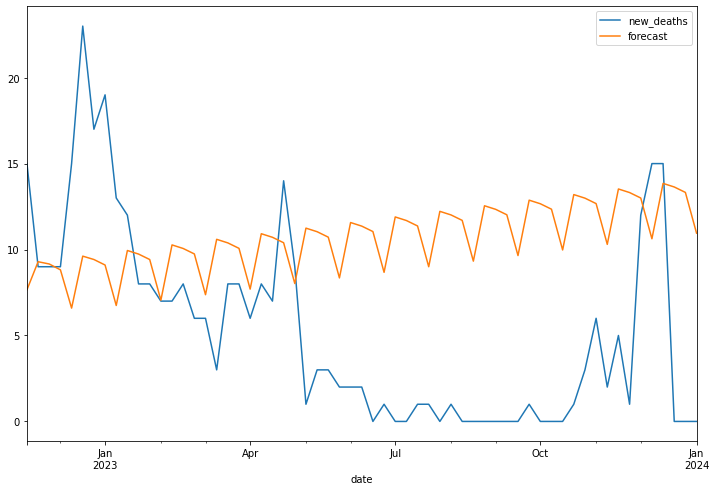

In [336]:
model=sm.tsa.statespace.SARIMAX(estonia_train['new_deaths'],order=(1, 1, 1),seasonal_order=(1,1,1,4))
results=model.fit()
estonia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
estonia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [337]:
mae = mean_absolute_error(estonia_test['new_deaths'], estonia_test['forecast'])
r2 = r2_score(estonia_test['new_deaths'], estonia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(estonia_test['new_deaths'], estonia_test['forecast'], y_train = estonia_train['new_deaths'])
new_row = {'country': 'Estonia', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [338]:
auto_model = auto_arima(estonia_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(estonia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -565.368
Date:                Tue, 27 Feb 2024   AIC                           1142.736
Time:                        18:42:20   BIC                           1160.429
Sample:                    03-01-2020   HQIC                          1149.926
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1387      1.400      0.813      0.416      -1.606       3.883
ar.L1          1.5261      0.216      7.071      0.000       1.103       1.949
ar.L2         -0.5945      0.201     -2.956      0.0

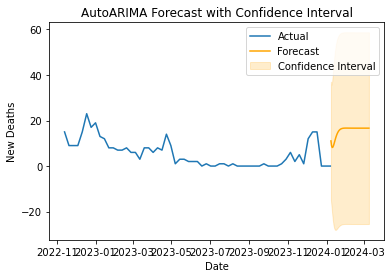

In [339]:
forecast_index = pd.date_range(estonia_test.index[-1], periods=n_periods + 1, freq=estonia_test.index.freq)[-n_periods:]

plt.plot(estonia_test.index, estonia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [340]:
mae = mean_absolute_error(estonia_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(estonia_test['new_deaths'], forecast, y_train = estonia_train['new_deaths'])
r2 = r2_score(estonia_test['new_deaths'], forecast)
new_row = {'country': 'Estonia', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# France

## train/test split

In [341]:
france = pd.read_csv('univariate_df_France.csv')
france = france.set_index('date')
france.index = pd.to_datetime(france.index)
france = france.drop('Unnamed: 0', axis=1)
france = france.drop('diff1', axis=1)
france.sort_index()
train_size = int(len(france) * 0.7)
france_train, france_test = france[0:train_size], france[train_size:]
print(france_train.shape, france_test.shape)

(141, 1) (61, 1)


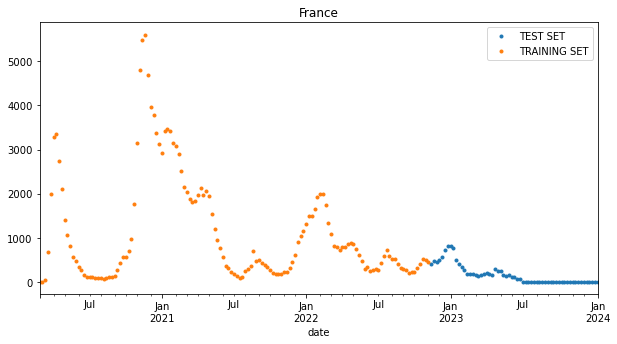

In [342]:
_ = france_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(france_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='France', style='.')

## basic ARIMA (1,1,1)

In [343]:
model=ARIMA(france_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -955.311
Date:                Tue, 27 Feb 2024   AIC                           1916.622
Time:                        18:42:22   BIC                           1925.447
Sample:                    03-01-2020   HQIC                          1920.208
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5745      0.054     10.646      0.000       0.469       0.680
ma.L1          0.3242      0.084      3.868      0.000       0.160       0.489
sigma2      4.922e+04   3363.258     14.635      0.000    4.26e+04    5.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               132.02
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

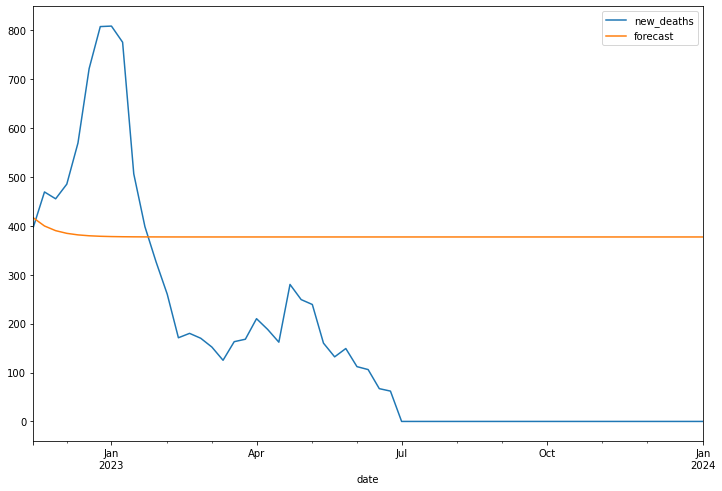

In [344]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [345]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(france_test['new_deaths'], france_test['forecast'], y_train = france_train['new_deaths'])
new_row = {'country': 'France', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [346]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(france_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
3,1,4,1904.172895
6,2,3,1904.364184
7,2,4,1905.911761
10,3,3,1905.988453
4,2,1,1906.173843
11,3,4,1906.236994
8,3,1,1906.878592
1,1,2,1907.411965
5,2,2,1907.455890
15,4,4,1908.283317


In [347]:
model=ARIMA(france_train['new_deaths'],order=(1,1,4))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -946.086
Date:                Tue, 27 Feb 2024   AIC                           1904.173
Time:                        18:42:34   BIC                           1921.823
Sample:                    03-01-2020   HQIC                          1911.345
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8864      0.036     24.431      0.000       0.815       0.958
ma.L1          0.0027      0.140      0.019      0.984      -0.273       0.278
ma.L2         -0.2366      0.107     -2.211      0.027      -0.446      -0.027
ma.L3         -0.4898      0.070     -6.976      0.000      -0.627      -0.352
ma.L4         -0.2763      0.068     -4.080      0.000      -0.409      -0.144
sigma2       4.24e+04   5.89e-06    7.2e+09      0.000    4.24e+04    4.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                86.52
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.08e+24. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

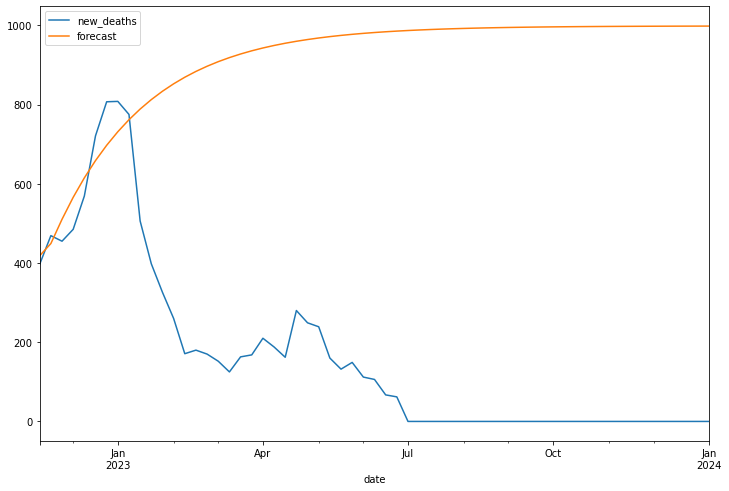

In [348]:
france_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [349]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(france_test['new_deaths'], france_test['forecast'], y_train = france_train['new_deaths'])
new_row = {'country': 'France', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [350]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78714D+00    |proj g|=  1.32632D-01

At iterate    5    f=  6.70769D+00    |proj g|=  8.60210D-03


 This problem is unconstrained.



At iterate   10    f=  6.70544D+00    |proj g|=  1.82021D-03

At iterate   15    f=  6.60433D+00    |proj g|=  4.36089D-02

At iterate   20    f=  6.59724D+00    |proj g|=  3.65887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   9.253D-06   6.597D+00
  F =   6.5972391959429366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72403D+00    |proj g|=  7.88503D-02


 This problem is unconstrained.



At iterate    5    f=  6.70883D+00    |proj g|=  3.11948D-03

At iterate   10    f=  6.70477D+00    |proj g|=  3.19404D-02

At iterate   15    f=  6.61425D+00    |proj g|=  2.32974D-02

At iterate   20    f=  6.61243D+00    |proj g|=  6.25155D-03

At iterate   25    f=  6.60423D+00    |proj g|=  3.77507D-02

At iterate   30    f=  6.60324D+00    |proj g|=  4.02862D-04

At iterate   35    f=  6.60322D+00    |proj g|=  2.99539D-03

At iterate   40    f=  6.60282D+00    |proj g|=  1.27103D-02

At iterate   45    f=  6.60177D+00    |proj g|=  1.30457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     78   

 This problem is unconstrained.



At iterate   15    f=  6.70349D+00    |proj g|=  4.87051D-03

At iterate   20    f=  6.59846D+00    |proj g|=  5.94901D-02

At iterate   25    f=  6.59348D+00    |proj g|=  2.12308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   3.740D-07   6.593D+00
  F =   6.5934765752269300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75129D+00    |proj g|=  1.39294D-01


 This problem is unconstrained.



At iterate    5    f=  6.70651D+00    |proj g|=  2.35773D-02

At iterate   10    f=  6.70551D+00    |proj g|=  1.64953D-03

At iterate   15    f=  6.70013D+00    |proj g|=  2.09221D-02

At iterate   20    f=  6.66209D+00    |proj g|=  3.18938D-02

At iterate   25    f=  6.59759D+00    |proj g|=  4.32237D-02

At iterate   30    f=  6.59007D+00    |proj g|=  2.77759D-02

At iterate   35    f=  6.58957D+00    |proj g|=  7.63894D-04

At iterate   40    f=  6.58891D+00    |proj g|=  2.83228D-02

At iterate   45    f=  6.58832D+00    |proj g|=  4.98931D-04

At iterate   50    f=  6.58831D+00    |proj g|=  1.79794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.66062D+00    |proj g|=  1.61958D-03

At iterate   15    f=  6.65565D+00    |proj g|=  1.95848D-02

At iterate   20    f=  6.55970D+00    |proj g|=  5.08455D-02

At iterate   25    f=  6.55611D+00    |proj g|=  4.68981D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   6.566D-06   6.556D+00
  F =   6.5561026711147976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  6.66370D+00    |proj g|=  2.97136D-03

At iterate   15    f=  6.65537D+00    |proj g|=  7.96131D-02

At iterate   20    f=  6.60922D+00    |proj g|=  6.75001D-02

At iterate   25    f=  6.56862D+00    |proj g|=  8.17661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     43      1     0     0   2.413D-04   6.569D+00
  F =   6.5686131134350250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.69604D+00    |proj g|=  7.12840D-02

At iterate   10    f=  6.66037D+00    |proj g|=  1.26550D-02

At iterate   15    f=  6.65926D+00    |proj g|=  2.08711D-03

At iterate   20    f=  6.65312D+00    |proj g|=  2.84720D-02

At iterate   25    f=  6.55684D+00    |proj g|=  4.16331D-02

At iterate   30    f=  6.55338D+00    |proj g|=  1.55054D-02

At iterate   35    f=  6.55266D+00    |proj g|=  1.53054D-03

At iterate   40    f=  6.55260D+00    |proj g|=  6.34341D-04

At iterate   45    f=  6.55259D+00    |proj g|=  1.96415D-04

At iterate   50    f=  6.55258D+00    |proj g|=  5.07557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.66279D+00    |proj g|=  1.84700D-02

At iterate   10    f=  6.66050D+00    |proj g|=  1.62119D-03

At iterate   15    f=  6.65473D+00    |proj g|=  3.71474D-02

At iterate   20    f=  6.55612D+00    |proj g|=  2.23760D-02

At iterate   25    f=  6.55510D+00    |proj g|=  1.34985D-03

At iterate   30    f=  6.55472D+00    |proj g|=  7.22654D-03

At iterate   35    f=  6.55466D+00    |proj g|=  6.35603D-04

At iterate   40    f=  6.55451D+00    |proj g|=  3.31345D-03

At iterate   45    f=  6.55261D+00    |proj g|=  2.19815D-02

At iterate   50    f=  6.55053D+00    |proj g|=  2.20695D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.60325D+00    |proj g|=  2.82194D-02

At iterate   15    f=  6.60230D+00    |proj g|=  2.57504D-03

At iterate   20    f=  6.60184D+00    |proj g|=  4.25547D-03

At iterate   25    f=  6.56464D+00    |proj g|=  2.42972D-02

At iterate   30    f=  6.56401D+00    |proj g|=  1.13162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     40      1     0     0   8.376D-06   6.564D+00
  F =   6.5640132831531401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.60576D+00    |proj g|=  2.26335D-02

At iterate   10    f=  6.60240D+00    |proj g|=  1.25165D-03

At iterate   15    f=  6.60211D+00    |proj g|=  2.72566D-03

At iterate   20    f=  6.59127D+00    |proj g|=  5.71416D-02

At iterate   25    f=  6.56189D+00    |proj g|=  6.98308D-02

At iterate   30    f=  6.55804D+00    |proj g|=  9.06627D-04

At iterate   35    f=  6.55688D+00    |proj g|=  7.43349D-03

At iterate   40    f=  6.55672D+00    |proj g|=  5.38354D-04

At iterate   45    f=  6.55670D+00    |proj g|=  8.39655D-05

At iterate   50    f=  6.55668D+00    |proj g|=  3.88285D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.66337D+00    |proj g|=  8.03996D-02

At iterate   10    f=  6.60942D+00    |proj g|=  3.04671D-02

At iterate   15    f=  6.60155D+00    |proj g|=  9.15114D-03

At iterate   20    f=  6.60048D+00    |proj g|=  2.27702D-03

At iterate   25    f=  6.60018D+00    |proj g|=  3.34141D-03

At iterate   30    f=  6.56141D+00    |proj g|=  1.89994D-02

At iterate   35    f=  6.56061D+00    |proj g|=  1.93032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     51      1     0     0   1.130D-05   6.561D+00
  F =   6.5606089856746781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.60662D+00    |proj g|=  2.61204D-02

At iterate   10    f=  6.60254D+00    |proj g|=  2.23430D-03

At iterate   15    f=  6.60225D+00    |proj g|=  2.16460D-03

At iterate   20    f=  6.59681D+00    |proj g|=  1.83731D-02

At iterate   25    f=  6.56017D+00    |proj g|=  4.56448D-02

At iterate   30    f=  6.55328D+00    |proj g|=  2.44251D-03

At iterate   35    f=  6.55320D+00    |proj g|=  3.57286D-03

At iterate   40    f=  6.55297D+00    |proj g|=  3.31871D-03

At iterate   45    f=  6.55284D+00    |proj g|=  5.31626D-04

At iterate   50    f=  6.55283D+00    |proj g|=  3.60609D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.61570D+00    |proj g|=  1.18983D-01

At iterate   10    f=  6.58402D+00    |proj g|=  7.09816D-03

At iterate   15    f=  6.58315D+00    |proj g|=  2.63364D-03

At iterate   20    f=  6.58263D+00    |proj g|=  3.36076D-03

At iterate   25    f=  6.58250D+00    |proj g|=  8.68548D-03

At iterate   30    f=  6.57358D+00    |proj g|=  7.66673D-02

At iterate   35    f=  6.56186D+00    |proj g|=  1.84103D-02

At iterate   40    f=  6.55672D+00    |proj g|=  7.69985D-03

At iterate   45    f=  6.55640D+00    |proj g|=  8.79017D-04

At iterate   50    f=  6.55639D+00    |proj g|=  3.73328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58432D+00    |proj g|=  1.41594D-02

At iterate   10    f=  6.58268D+00    |proj g|=  2.34977D-03

At iterate   15    f=  6.58244D+00    |proj g|=  1.09659D-03

At iterate   20    f=  6.57921D+00    |proj g|=  3.36881D-02

At iterate   25    f=  6.55915D+00    |proj g|=  4.24630D-02

At iterate   30    f=  6.55055D+00    |proj g|=  3.38005D-03

At iterate   35    f=  6.54977D+00    |proj g|=  6.29647D-03

At iterate   40    f=  6.54872D+00    |proj g|=  1.26378D-02

At iterate   45    f=  6.54835D+00    |proj g|=  3.00530D-04

At iterate   50    f=  6.54835D+00    |proj g|=  6.95270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.63360D+00    |proj g|=  1.51538D-01

At iterate   10    f=  6.58464D+00    |proj g|=  2.43637D-02

At iterate   15    f=  6.58080D+00    |proj g|=  1.12144D-03

At iterate   20    f=  6.58038D+00    |proj g|=  7.95861D-03

At iterate   25    f=  6.57968D+00    |proj g|=  3.67766D-03

At iterate   30    f=  6.57729D+00    |proj g|=  2.94935D-02

At iterate   35    f=  6.55559D+00    |proj g|=  2.54261D-02

At iterate   40    f=  6.55323D+00    |proj g|=  3.47771D-03

At iterate   45    f=  6.55320D+00    |proj g|=  5.15851D-04

At iterate   50    f=  6.55317D+00    |proj g|=  1.66143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.58550D+00    |proj g|=  3.53486D-02

At iterate   10    f=  6.58329D+00    |proj g|=  1.18867D-02

At iterate   15    f=  6.58248D+00    |proj g|=  9.50360D-03

At iterate   20    f=  6.58226D+00    |proj g|=  1.36481D-03

At iterate   25    f=  6.58141D+00    |proj g|=  3.07353D-02

At iterate   30    f=  6.57755D+00    |proj g|=  9.48377D-03

At iterate   35    f=  6.56557D+00    |proj g|=  4.04623D-02

At iterate   40    f=  6.55464D+00    |proj g|=  1.24824D-02

At iterate   45    f=  6.55388D+00    |proj g|=  5.57239D-04

At iterate   50    f=  6.55387D+00    |proj g|=  1.77614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [351]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
4,1,2,1,1,1860.820953
6,1,2,2,1,1861.828687
13,2,2,1,2,1862.633392
12,2,2,1,1,1862.903025
9,2,1,1,2,1862.984575
8,2,1,1,1,1863.051746
7,1,2,2,2,1863.250805
11,2,1,2,2,1863.899439
14,2,2,2,1,1863.993953
10,2,1,2,1,1864.091734


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76502D+00    |proj g|=  1.42535D-01

At iterate    5    f=  6.66660D+00    |proj g|=  3.61919D-02


 This problem is unconstrained.



At iterate   10    f=  6.66062D+00    |proj g|=  1.61958D-03

At iterate   15    f=  6.65565D+00    |proj g|=  1.95848D-02

At iterate   20    f=  6.55970D+00    |proj g|=  5.08455D-02

At iterate   25    f=  6.55611D+00    |proj g|=  4.68981D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   6.566D-06   6.556D+00
  F =   6.5561026711147976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<AxesSubplot:xlabel='date'>

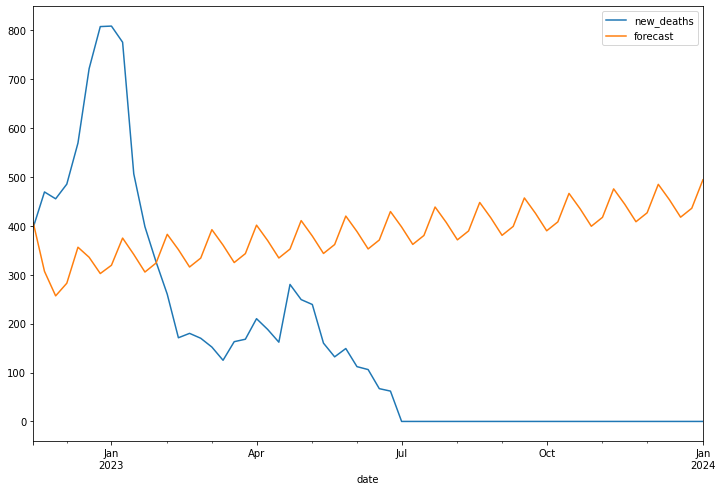

In [352]:
model=sm.tsa.statespace.SARIMAX(france_train['new_deaths'],order=(1, 1, 2),seasonal_order=(1,1,1,4))
results=model.fit()
france_test['forecast']=results.predict(start=141,end=202,dynamic=True)
france_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [353]:
mae = mean_absolute_error(france_test['new_deaths'], france_test['forecast'])
r2 = r2_score(france_test['new_deaths'], france_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(france_test['new_deaths'], france_test['forecast'], y_train = france_train['new_deaths'])
new_row = {'country': 'France', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [354]:
auto_model = auto_arima(france_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(france_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -953.040
Date:                Tue, 27 Feb 2024   AIC                           1918.081
Time:                        18:43:13   BIC                           1935.773
Sample:                    03-01-2020   HQIC                          1925.270
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.6837     63.218      1.482      0.138     -30.222     217.589
ar.L1          1.3268      0.075     17.717      0.000       1.180       1.474
ar.L2         -0.4172      0.073     -5.715      0.0

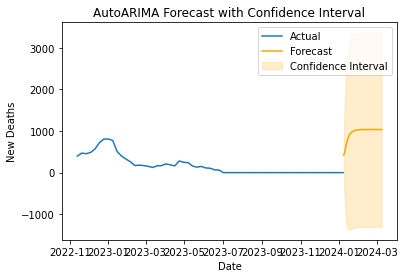

In [355]:
forecast_index = pd.date_range(france_test.index[-1], periods=n_periods + 1, freq=france_test.index.freq)[-n_periods:]

plt.plot(france_test.index, france_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [356]:
mae = mean_absolute_error(france_test['new_deaths'], forecast)
r2 = r2_score(france_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(france_test['new_deaths'], forecast, y_train = france_train['new_deaths'])
new_row = {'country': 'France', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Malaysia

## train/test split

In [357]:
malaysia = pd.read_csv('univariate_df_Malaysia.csv')
malaysia = malaysia.set_index('date')
malaysia.index = pd.to_datetime(malaysia.index)
malaysia = malaysia.drop('Unnamed: 0', axis=1)
malaysia = malaysia.drop('diff1', axis=1)
malaysia.sort_index()
train_size = int(len(malaysia) * 0.7)
malaysia_train, malaysia_test = malaysia[0:train_size], malaysia[train_size:]
print(malaysia_train.shape, malaysia_test.shape)

(141, 1) (61, 1)


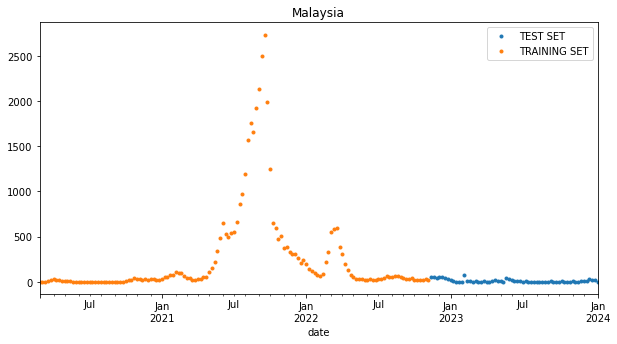

In [358]:
_ = malaysia_test \
    .rename(columns={'new_deaths': 'TEST SET'}) \
    .join(malaysia_train.rename(columns={'new_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='Malaysia', style='.')

## basic ARIMA (1,1,1)

In [359]:
model=ARIMA(malaysia_train['new_deaths'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -849.761
Date:                Tue, 27 Feb 2024   AIC                           1705.521
Time:                        18:43:17   BIC                           1714.346
Sample:                    03-01-2020   HQIC                          1709.108
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4641      0.065      7.148      0.000       0.337       0.591
ma.L1          0.1839      0.077      2.376      0.017       0.032       0.336
sigma2      1.092e+04    443.854     24.606      0.000    1.01e+04    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              6050.75
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              29.24   Skew:                            -3.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

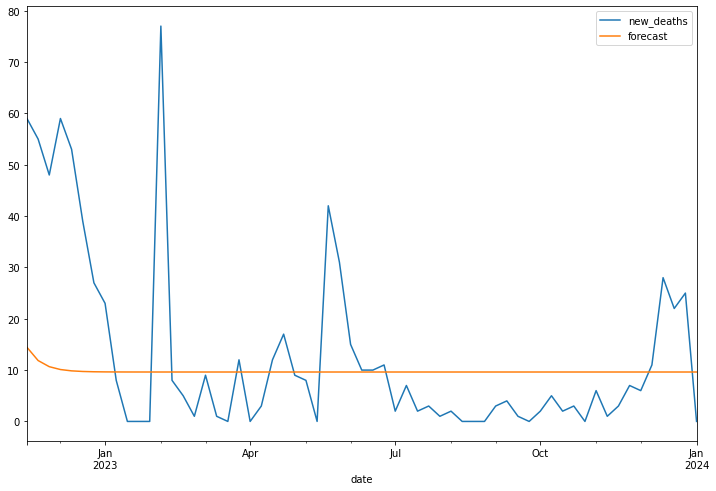

In [360]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [361]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(malaysia_test['new_deaths'], malaysia_test['forecast'], y_train = malaysia_train['new_deaths'])
new_row = {'country': 'Malaysia', 'model': 'Basic ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search ARIMA

In [362]:
results=[]
for p in range(1,5):
    for q in range(1,5):
        model=ARIMA(malaysia_train['new_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
9,3,2,1693.222428
6,2,3,1693.416992
11,3,4,1694.127175
5,2,2,1694.471179
7,2,4,1695.208367
13,4,2,1695.221904
10,3,3,1695.222291
15,4,4,1695.554666
14,4,3,1696.944360
3,1,4,1697.775995


In [363]:
model=ARIMA(malaysia_train['new_deaths'],order=(3,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             new_deaths   No. Observations:                  141
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -840.611
Date:                Tue, 27 Feb 2024   AIC                           1693.222
Time:                        18:43:28   BIC                           1710.872
Sample:                    03-01-2020   HQIC                          1700.395
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6827      0.124      5.491      0.000       0.439       0.926
ar.L2         -0.7409      0.151     -4.919      0.000      -1.036      -0.446
ar.L3          0.2037      0.083      2.459      0.014       0.041       0.366
ma.L1         -0.0162      0.120     -0.135      0.892      -0.251       0.219
ma.L2          0.7713      0.104      7.401      0.000       0.567       0.976
sigma2      9532.6325    527.536     18.070      0.000    8498.681    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4852.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              23.29   Skew:                            -3.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

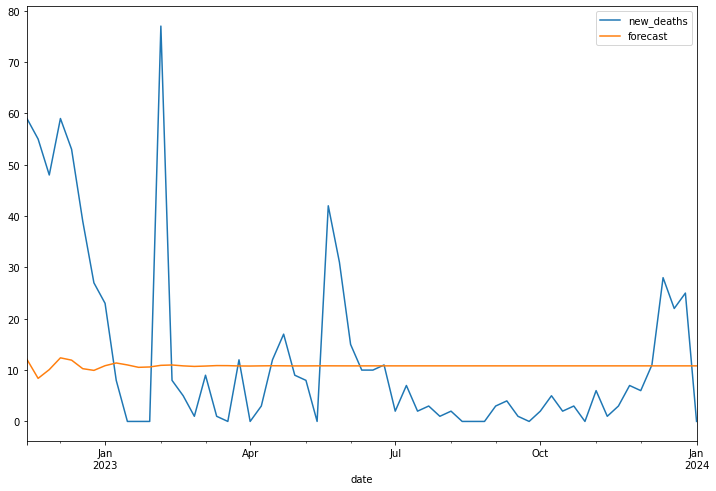

In [364]:
malaysia_test['forecast']=model_fit.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [365]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(malaysia_test['new_deaths'], malaysia_test['forecast'], y_train = malaysia_train['new_deaths'])
new_row = {'country': 'Malaysia', 'model': 'Grid Search ARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## grid search SARIMA

In [366]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05842D+00    |proj g|=  5.57238D-02

At iterate    5    f=  6.02911D+00    |proj g|=  8.36541D-03


 This problem is unconstrained.



At iterate   10    f=  6.02483D+00    |proj g|=  1.50084D-02

At iterate   15    f=  5.91496D+00    |proj g|=  9.04084D-02

At iterate   20    f=  5.90765D+00    |proj g|=  4.79565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   6.317D-06   5.908D+00
  F =   5.9076542405911638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03824D+00    |proj g|=  2.16773D-02


 This problem is unconstrained.



At iterate   15    f=  5.93721D+00    |proj g|=  1.32091D-01

At iterate   20    f=  5.91114D+00    |proj g|=  4.66783D-02

At iterate   25    f=  5.90340D+00    |proj g|=  2.67428D-03

At iterate   30    f=  5.89991D+00    |proj g|=  1.18837D-02

At iterate   35    f=  5.89910D+00    |proj g|=  3.45481D-03

At iterate   40    f=  5.89894D+00    |proj g|=  6.81338D-04

At iterate   45    f=  5.89891D+00    |proj g|=  6.53946D-04

At iterate   50    f=  5.89891D+00    |proj g|=  3.91346D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   3.913D-05   5.899D+00
  F =   5.89890640120

 This problem is unconstrained.



At iterate   20    f=  5.89401D+00    |proj g|=  1.10580D-02

At iterate   25    f=  5.89375D+00    |proj g|=  5.20357D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   5.204D-06   5.894D+00
  F =   5.8937483763403140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03094D+00    |proj g|=  3.15894D-02

At iterate    5    f=  6.02568D+00    |proj g|=  3.61416D-03


 This problem is unconstrained.



At iterate   10    f=  6.02086D+00    |proj g|=  2.57099D-02

At iterate   15    f=  5.98845D+00    |proj g|=  2.64433D-02

At iterate   20    f=  5.90864D+00    |proj g|=  2.94383D-03

At iterate   25    f=  5.90862D+00    |proj g|=  1.43844D-03

At iterate   30    f=  5.90749D+00    |proj g|=  1.65519D-02

At iterate   35    f=  5.90238D+00    |proj g|=  3.15706D-02

At iterate   40    f=  5.90145D+00    |proj g|=  2.84511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     60      1     0     0   2.209D-06   5.901D+00
  F =   5.9014473373256289     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  6.02925D+00    |proj g|=  8.55130D-03

At iterate   10    f=  6.02711D+00    |proj g|=  7.90133D-03

At iterate   15    f=  5.95739D+00    |proj g|=  8.39436D-02

At iterate   20    f=  5.93698D+00    |proj g|=  6.72548D-02

At iterate   25    f=  5.88410D+00    |proj g|=  1.50965D-02

At iterate   30    f=  5.88374D+00    |proj g|=  7.04965D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   7.050D-06   5.884D+00
  F =   5.8837377089352572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  6.03672D+00    |proj g|=  1.84812D-02

At iterate   15    f=  5.98707D+00    |proj g|=  1.51912D-01

At iterate   20    f=  5.92899D+00    |proj g|=  1.21332D-02

At iterate   25    f=  5.90161D+00    |proj g|=  2.22912D-02

At iterate   30    f=  5.87803D+00    |proj g|=  3.31196D-02

At iterate   35    f=  5.87186D+00    |proj g|=  1.99379D-03

At iterate   40    f=  5.87181D+00    |proj g|=  5.59715D-04

At iterate   45    f=  5.87161D+00    |proj g|=  4.60442D-03

At iterate   50    f=  5.87151D+00    |proj g|=  2.31617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



At iterate    5    f=  6.02445D+00    |proj g|=  2.71529D-02

At iterate   10    f=  6.02099D+00    |proj g|=  5.31817D-03

At iterate   15    f=  6.01803D+00    |proj g|=  1.49332D-02

At iterate   20    f=  5.96468D+00    |proj g|=  1.53208D-01

At iterate   25    f=  5.94689D+00    |proj g|=  4.32373D-03

At iterate   30    f=  5.94194D+00    |proj g|=  4.18530D-02

At iterate   35    f=  5.93572D+00    |proj g|=  2.32979D-02

At iterate   40    f=  5.90724D+00    |proj g|=  2.22240D-01

At iterate   45    f=  5.86392D+00    |proj g|=  2.67214D-02

At iterate   50    f=  5.86284D+00    |proj g|=  1.18983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  6.01518D+00    |proj g|=  1.36415D-02

At iterate   20    f=  5.94304D+00    |proj g|=  1.22694D-01

At iterate   25    f=  5.89039D+00    |proj g|=  7.31553D-03

At iterate   30    f=  5.88789D+00    |proj g|=  4.33159D-02

At iterate   35    f=  5.88333D+00    |proj g|=  3.78707D-03

At iterate   40    f=  5.88330D+00    |proj g|=  8.05877D-04

At iterate   45    f=  5.88269D+00    |proj g|=  2.19245D-02

At iterate   50    f=  5.87411D+00    |proj g|=  9.40874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   9.409D-03   5.874D+00
  F =   5.87411051169

 This problem is unconstrained.



At iterate   20    f=  5.97006D+00    |proj g|=  1.07136D-02

At iterate   25    f=  5.90807D+00    |proj g|=  1.03163D-01

At iterate   30    f=  5.89747D+00    |proj g|=  5.54331D-03

At iterate   35    f=  5.89668D+00    |proj g|=  8.81063D-04

At iterate   40    f=  5.89661D+00    |proj g|=  6.55036D-05

At iterate   45    f=  5.89661D+00    |proj g|=  1.94744D-04

At iterate   50    f=  5.89660D+00    |proj g|=  2.08150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   2.082D-04   5.897D+00
  F =   5.8966038039213737     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  5.98410D+00    |proj g|=  6.03179D-03

At iterate   10    f=  5.98018D+00    |proj g|=  5.04509D-03

At iterate   15    f=  5.97056D+00    |proj g|=  8.79281D-02

At iterate   20    f=  5.92122D+00    |proj g|=  1.83880D-02

At iterate   25    f=  5.92034D+00    |proj g|=  5.81195D-04

At iterate   30    f=  5.92023D+00    |proj g|=  6.37225D-04

At iterate   35    f=  5.92017D+00    |proj g|=  8.75446D-04

At iterate   40    f=  5.92002D+00    |proj g|=  1.01243D-03

At iterate   45    f=  5.92002D+00    |proj g|=  5.98366D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     54   

 This problem is unconstrained.



At iterate    5    f=  5.98631D+00    |proj g|=  2.31982D-02

At iterate   10    f=  5.97195D+00    |proj g|=  8.44404D-03

At iterate   15    f=  5.96971D+00    |proj g|=  8.69489D-03

At iterate   20    f=  5.96683D+00    |proj g|=  2.15244D-02

At iterate   25    f=  5.90790D+00    |proj g|=  7.65827D-02

At iterate   30    f=  5.88244D+00    |proj g|=  1.86106D-02

At iterate   35    f=  5.88175D+00    |proj g|=  3.76093D-03

At iterate   40    f=  5.88146D+00    |proj g|=  1.94604D-03

At iterate   45    f=  5.88141D+00    |proj g|=  1.71713D-04

At iterate   50    f=  5.88141D+00    |proj g|=  1.57488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  5.97033D+00    |proj g|=  7.67374D-03

At iterate   20    f=  5.95994D+00    |proj g|=  2.26121D-02

At iterate   25    f=  5.90762D+00    |proj g|=  4.62129D-02

At iterate   30    f=  5.90482D+00    |proj g|=  1.84066D-03

At iterate   35    f=  5.90111D+00    |proj g|=  3.18121D-02

At iterate   40    f=  5.89547D+00    |proj g|=  1.08409D-02

At iterate   45    f=  5.89192D+00    |proj g|=  2.60315D-02

At iterate   50    f=  5.89034D+00    |proj g|=  1.41149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   1.411D-03   5.890D+00
  F =   5.89034380249

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03736D+00    |proj g|=  1.09081D-01

At iterate    5    f=  5.99139D+00    |proj g|=  1.39372D-01

At iterate   10    f=  5.97487D+00    |proj g|=  5.00980D-02

At iterate   15    f=  5.97216D+00    |proj g|=  3.41802D-03

At iterate   20    f=  5.96868D+00    |proj g|=  8.44072D-03

At iterate   25    f=  5.95661D+00    |proj g|=  9.39741D-02

At iterate   30    f=  5.90297D+00    |proj g|=  3.79087D-01

At iterate   35    f=  5.86173D+00    |proj g|=  5.83439D-02

At iterate   40    f=  5.85996D+00    |proj g|=  1.12482D-02

At iterate   45    f=  5.85896D+00    |proj g|=  2.98796D-03

At iterate   50    f=  5.85882D+00    |proj g|=  2.80093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  5.97819D+00    |proj g|=  7.08869D-03

At iterate   15    f=  5.97592D+00    |proj g|=  1.07180D-02

At iterate   20    f=  5.95566D+00    |proj g|=  6.50047D-02

At iterate   25    f=  5.92183D+00    |proj g|=  1.63617D-02

At iterate   30    f=  5.89745D+00    |proj g|=  1.35071D-01

At iterate   35    f=  5.88928D+00    |proj g|=  1.74249D-02

At iterate   40    f=  5.86280D+00    |proj g|=  6.89121D-02

At iterate   45    f=  5.86157D+00    |proj g|=  8.47532D-04

At iterate   50    f=  5.86116D+00    |proj g|=  1.16304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64   

 This problem is unconstrained.



At iterate   10    f=  5.96662D+00    |proj g|=  3.47861D-03

At iterate   15    f=  5.96545D+00    |proj g|=  1.08700D-02

At iterate   20    f=  5.94465D+00    |proj g|=  4.30465D-02

At iterate   25    f=  5.89923D+00    |proj g|=  3.71396D-01

At iterate   30    f=  5.88767D+00    |proj g|=  1.92735D-02

At iterate   35    f=  5.86990D+00    |proj g|=  1.49469D-01

At iterate   40    f=  5.84952D+00    |proj g|=  3.67640D-02

At iterate   45    f=  5.84759D+00    |proj g|=  7.21494D-03

At iterate   50    f=  5.84548D+00    |proj g|=  1.37577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99513D+00    |proj g|=  1.07071D-01

At iterate    5    f=  5.97396D+00    |proj g|=  1.88181D-02

At iterate   10    f=  5.96717D+00    |proj g|=  1.37278D-02

At iterate   15    f=  5.96542D+00    |proj g|=  9.48317D-03

At iterate   20    f=  5.96211D+00    |proj g|=  1.16449D-02

At iterate   25    f=  5.86738D+00    |proj g|=  1.54499D-01

At iterate   30    f=  5.85924D+00    |proj g|=  4.19957D-03

At iterate   35    f=  5.85914D+00    |proj g|=  3.37275D-03

At iterate   40    f=  5.85863D+00    |proj g|=  2.77205D-02

At iterate   45    f=  5.85465D+00    |proj g|=  4.08287D-02

At iterate   50    f=  5.85240D+00    |proj g|=  2.00799D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [367]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
14,2,2,2,1,1664.426571
12,2,2,1,1,1666.186997
6,1,2,2,1,1667.319476
15,2,2,2,2,1668.378173
13,2,2,1,2,1668.848289
5,1,2,1,2,1669.766593
4,1,2,1,1,1671.214034
7,1,2,2,2,1672.499164
10,2,1,2,1,1672.557664
2,1,1,2,1,1674.037042


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04008D+00    |proj g|=  2.05323D-01

At iterate    5    f=  5.98180D+00    |proj g|=  7.80895D-02


 This problem is unconstrained.



At iterate   10    f=  5.96662D+00    |proj g|=  3.47861D-03

At iterate   15    f=  5.96545D+00    |proj g|=  1.08700D-02

At iterate   20    f=  5.94465D+00    |proj g|=  4.30465D-02

At iterate   25    f=  5.89923D+00    |proj g|=  3.71396D-01

At iterate   30    f=  5.88767D+00    |proj g|=  1.92735D-02

At iterate   35    f=  5.86990D+00    |proj g|=  1.49469D-01

At iterate   40    f=  5.84952D+00    |proj g|=  3.67640D-02

At iterate   45    f=  5.84759D+00    |proj g|=  7.21494D-03

At iterate   50    f=  5.84548D+00    |proj g|=  1.37577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70   

<AxesSubplot:xlabel='date'>

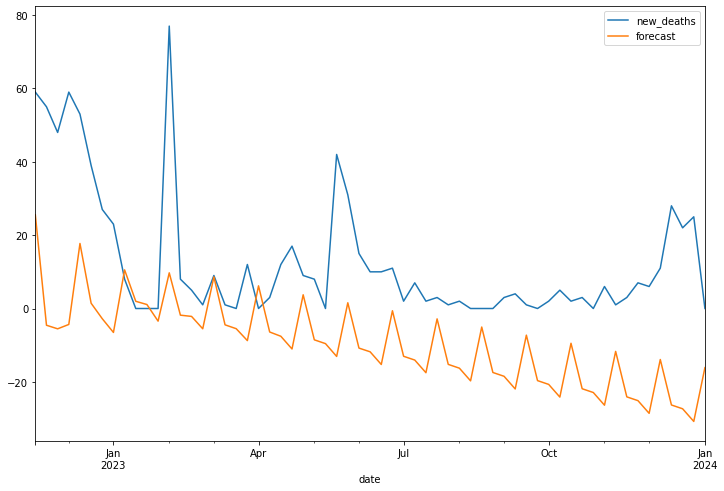

In [368]:
model=sm.tsa.statespace.SARIMAX(malaysia_train['new_deaths'],order=(2, 1, 2),seasonal_order=(2,1,1,4))
results=model.fit()
malaysia_test['forecast']=results.predict(start=141,end=202,dynamic=True)
malaysia_test[['new_deaths','forecast']].plot(figsize=(12,8))

In [369]:
mae = mean_absolute_error(malaysia_test['new_deaths'], malaysia_test['forecast'])
r2 = r2_score(malaysia_test['new_deaths'], malaysia_test['forecast'])
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(malaysia_test['new_deaths'], malaysia_test['forecast'], y_train = malaysia_train['new_deaths'])
new_row = {'country': 'Malaysia', 'model': 'SARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

## autoARIMA

In [370]:
auto_model = auto_arima(malaysia_train['new_deaths'], seasonal=True, m=4, suppress_warnings=True, stepwise=True)

print(auto_model.summary())
n_periods=len(malaysia_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -853.332
Date:                Tue, 27 Feb 2024   AIC                           1714.663
Time:                        18:43:55   BIC                           1726.458
Sample:                    03-01-2020   HQIC                          1719.456
                         - 11-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6397      0.060     27.430      0.000       1.523       1.757
ar.L2         -0.8251      0.104     -7.956      0.000      -1.028      -0.622
ar.L3          0.1468      0.054      2.724      0.0

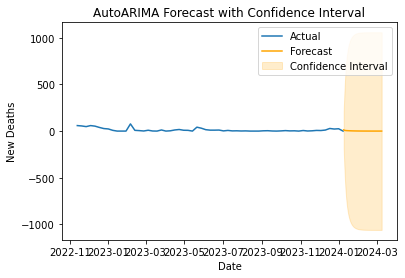

In [371]:
forecast_index = pd.date_range(malaysia_test.index[-1], periods=n_periods + 1, freq=malaysia_test.index.freq)[-n_periods:]

plt.plot(malaysia_test.index, malaysia_test['new_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [372]:
mae = mean_absolute_error(malaysia_test['new_deaths'], forecast)
r2 = r2_score(malaysia_test['new_deaths'], forecast)
mase = MeanAbsoluteScaledError(sp = 4)
mase = mase(malaysia_test['new_deaths'], forecast, y_train = malaysia_train['new_deaths'])
new_row = {'country': 'Malaysia', 'model': 'autoARIMA', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [373]:
metrics

,country,model,mae,mase,rsq
0,Belgium,Basic ARIMA,165.191065,0.834514,-38.595632
1,Belgium,Grid Search ARIMA,198.195833,1.001247,-52.903511
2,Belgium,SARIMA,18.906775,0.095513,0.382111
3,Belgium,autoARIMA,69.654506,0.351881,-6.505454
4,Chile,Basic ARIMA,410.619936,1.251862,-218.165242
5,Chile,Grid Search ARIMA,519.354774,1.583363,-398.751767
6,Chile,SARIMA,209.769004,0.639525,-66.443915
7,Chile,autoARIMA,414.973957,1.265136,-222.394029
8,Ireland,Basic ARIMA,34.795491,0.717271,-5.670918
9,Ireland,Grid Search ARIMA,36.663036,0.755768,-6.424504


In [374]:
metrics.sort_values('mase')

,country,model,mae,mase,rsq
36,Malaysia,Basic ARIMA,11.945929,0.069868,0.003771
39,Malaysia,autoARIMA,11.990284,0.070128,-0.237337
37,Malaysia,Grid Search ARIMA,12.493563,0.073071,-0.013499
2,Belgium,SARIMA,18.906775,0.095513,0.382111
24,Czechia,Basic ARIMA,21.790757,0.11739,-0.29174
38,Malaysia,SARIMA,22.971947,0.134356,-1.456577
26,Czechia,SARIMA,28.652892,0.154357,-1.26164
18,Italy,SARIMA,141.89025,0.188988,0.197184
14,Israel,SARIMA,13.37935,0.192883,-0.838873
25,Czechia,Grid Search ARIMA,40.051461,0.215762,-3.220581
